**Asthma Emergency Department Utilization Analysis**
**Project Title**
**Asthma Emergency Department Utilization**

**Focus: Evesham Township, New Jersey**
This notebook provides an in-depth analysis of asthma-related emergency department (ED) utilization across New Jersey municipalities, with a specific focus on Evesham Township. Through exploratory data analysis (EDA) and statistical methods, we aim to understand the drivers behind ED visits for asthma and inform public health interventions.

**Research Question:**
**Primary Research Question:** How do asthma emergency-department visit rates in Evesham Township compare with rates in other municipalities in Burlington County, Camden County, and New Jersey overall?

**Secondary Research Question:** Which factors, socioeconomic or environmental, appear to be most strongly associated with higher asthma emergency-department utilization, and what implications do these findings have for local public health or planning interventions?

**Install scikit-optimize library**

In [ ]:
!pip install scikit-optimize

**Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
import time
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from skopt.utils import use_named_args
from sklearn.metrics import mean_squared_error, r2_score
from skopt.space import Real, Integer
from skopt import gp_minimize

**Upload asthma_ed_cleaned.csv file**

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving asthma_ed_cleaned.csv to asthma_ed_cleaned.csv


**Read asthma_ed_cleaned.csv file and get info**

In [ ]:
df = pd.read_csv("asthma_ed_cleaned.csv")
df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   State_Municipality_County             77 non-null     object 
 1   State_Municipality_County_Level_Type  77 non-null     object 
 2   County                                74 non-null     object 
 3   Summary_Report_URL                    77 non-null     object 
 4   Total_Population                      77 non-null     int64  
 5   Poverty_%_Under_2x                    77 non-null     float64
 6   Minority_%                            77 non-null     float64
 7   No_Health_Insurance_%                 77 non-null     float64
 8   Traffic_%_1000ft_Heavy                77 non-null     float64
 9   Asthma_ED_Rate_10k                    56 non-null     float64
 10  Air_Cancer_Risk                       77 non-null     int64  
 11  Air_Non_Cancer       

## **Dataset Overview**

The dataset includes asthma ED utilization and social determinants of health
for multiple geographic levels:
- State
- County
- Municipality


## **Column Definitions**

This dataset includes state, county, and municipality-level records.
All analysis below is restricted to municipality-level rows unless stated otherwise.


In [ ]:
df.info()
COL_GEO = "State_Municipality_County"
COL_LEVEL = "State_Municipality_County_Level_Type"
COL_COUNTY = "County"
COL_POPULATION = "Total_Population"
COL_ASTHMA = "Asthma_ED_Rate_10k"
COL_POVERTY = "Poverty_%_Under_2x"
COL_UNINSURED = "No_Health_Insurance_%"
COL_TRAFFIC = "Traffic_%_1000ft_Heavy"
COL_MINORITY = "Minority_%"
COL_Air_Cancer_Risk = "Air_Cancer_Risk"
COL_Air_Non_Cancer = "Air_Non_Cancer"
COL_Air_Quality_Index = "Air_Quality_Index"
COL_Flooding_Urban_Land_Cover = "Flooding_Urban_Land_Cover"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   State_Municipality_County             77 non-null     object 
 1   State_Municipality_County_Level_Type  77 non-null     object 
 2   County                                74 non-null     object 
 3   Summary_Report_URL                    77 non-null     object 
 4   Total_Population                      77 non-null     int64  
 5   Poverty_%_Under_2x                    77 non-null     float64
 6   Minority_%                            77 non-null     float64
 7   No_Health_Insurance_%                 77 non-null     float64
 8   Traffic_%_1000ft_Heavy                77 non-null     float64
 9   Asthma_ED_Rate_10k                    56 non-null     float64
 10  Air_Cancer_Risk                       77 non-null     int64  
 11  Air_Non_Cancer       

## **Data Preparation & Subsetting**

To ensure valid comparisons:
- State and county rows are excluded from analysis
- Only municipality-level data is used
- Evesham Township is isolated as the focal municipality


## **Define Geographic Subsets**

We isolate Evesham Township and define comparison groups using
municipality-level data only.


In [ ]:
# First, load a fresh, unfiltered copy of the data to ensure we have all state/county rows.
df_full_original = pd.read_csv("asthma_ed_cleaned.csv")

# Isolate the specific row for Evesham Township, ensuring it's a municipality-level record.
# This is done from the 'df' which has already undergone dropna and transformations.
evesham_row = df[
    (df[COL_GEO] == "Evesham Township") &
    (df[COL_LEVEL] == "Municipality")
].iloc[0]

# Isolate specific row for New Jersey from the full original data
nj_row = df_full_original[df_full_original[COL_LEVEL] == "State"].iloc[0]

# Isolate the specific row for Burlington County from the full original data.
burlington_county_row = df_full_original[
    (df_full_original[COL_GEO] == "Burlington County") &
    (df_full_original[COL_LEVEL] == "County")
].iloc[0]

# Isolate the specific row for Camden County from the full original data.
camden_county_row = df_full_original[
    (df_full_original[COL_GEO] == "Camden County") &
    (df_full_original[COL_LEVEL] == "County")
].iloc[0]

# Create a DataFrame containing only municipality-level data for New Jersey from the *modified* df.
nj_muni_df = df[df[COL_LEVEL] == "Municipality"].copy()

# Filter the New Jersey municipalities to get only those in Burlington County.
burlington_df = nj_muni_df[nj_muni_df[COL_COUNTY] == "Burlington"]

# Filter the New Jersey municipalities to get only those in Camden County.
camden_df = nj_muni_df[nj_muni_df[COL_COUNTY] == "Camden"]
print(burlington_county_row)
print(camden_county_row)

State_Municipality_County                                               Burlington County
State_Municipality_County_Level_Type                                               County
County                                                                                NaN
Summary_Report_URL                      https://www.nj.gov/health/hcpnj/documents/coun...
Total_Population                                                                   446301
Poverty_%_Under_2x                                                                   15.8
Minority_%                                                                           33.4
No_Health_Insurance_%                                                                 4.4
Traffic_%_1000ft_Heavy                                                               12.4
Asthma_ED_Rate_10k                                                                   50.1
Air_Cancer_Risk                                                                        99
Air_Non_Ca

## **Distribution Analysis**

Histogram Showing the Distribution of Asthma Emergency Department Visit Rates

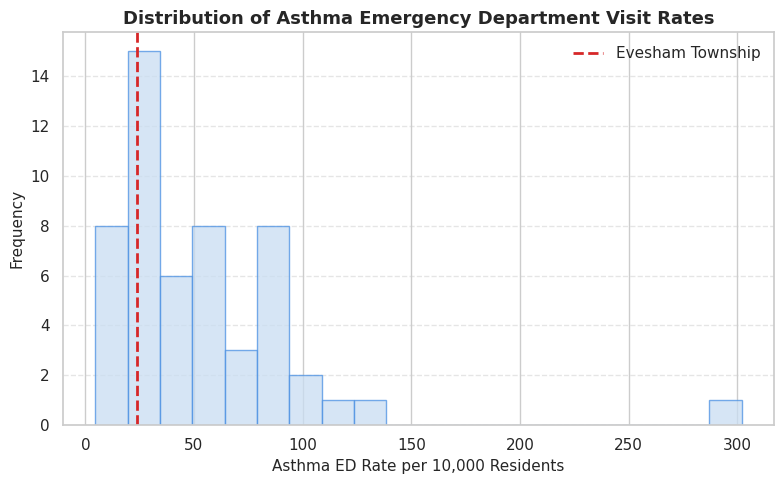

In [ ]:
# Prepare data (drop missing values)
asthma_values = nj_muni_df[COL_ASTHMA].dropna()


plt.figure(figsize=(8,5))

# Histogram
plt.hist(
    asthma_values,
    bins=20,
    color = "#C9DDF2",
    edgecolor= "#4A90E2",
    alpha=0.75
)

#Evesham Overlay
plt.axvline(
    evesham_row[COL_ASTHMA],
    linestyle="--",
    linewidth=2,
    label="Evesham Township",
    color="#D62728"
)

plt.legend(frameon=False)

# Titles and labels
plt.title(
    "Distribution of Asthma Emergency Department Visit Rates",
    fontsize=13,
    weight="bold"
)
plt.xlabel("Asthma ED Rate per 10,000 Residents", fontsize=11)
plt.ylabel("Frequency", fontsize=11)

# Grid for readability
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


The distribution of asthma ED visit rates across municipalities is right-skewed, indicating that most municipalities have lower rates while a few have significantly higher rates. Evesham Township's rate, highlighted on the histogram, falls at the lower end of this skewed distribution.

Applying sqrt transformation to asthma values distribution

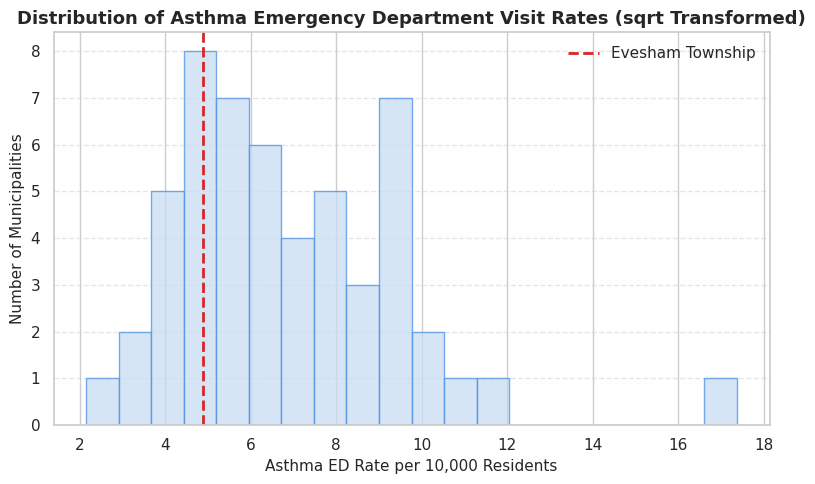

In [ ]:
# Prepare data (drop missing values)
asthma_values = nj_muni_df[COL_ASTHMA].dropna()
# Apply log transformation
#asthma_transformed = np.log(asthma_values)
asthma_transformed = np.sqrt(asthma_values)
#asthma_transformed = np.arcsin(np.sqrt(asthma_values/100))

# Calculate the transformed Evesham
#evesham_transformed = np.log1p(evesham_row[COL_No_Health_Insurance])
evesham_transformed = np.sqrt(evesham_row[COL_ASTHMA])
#evesham_transformed = np.arcsin(np.sqrt(evesham_row[COL_ASTHMA] / 100))


plt.figure(figsize=(8,5))

# Histogram
plt.hist(
    asthma_transformed,
    bins=20,
    color = "#C9DDF2",
    edgecolor= "#4A90E2",
    alpha=0.75
)

#Evesham Overlay
plt.axvline(
    evesham_transformed,
    linestyle="--",
    linewidth=2,
    label="Evesham Township",
    color="#D62728"
)

plt.legend(frameon=False)

# Titles and labels
plt.title(
    "Distribution of Asthma Emergency Department Visit Rates (sqrt Transformed)",
    fontsize=13,
    weight="bold"
)
plt.xlabel("Asthma ED Rate per 10,000 Residents", fontsize=11)
plt.ylabel("Number of Municipalities", fontsize=11)

# Grid for readability
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


This histogram shows that applying a square root transformation successfully reduced the right-skewness of the asthma ED visit rates, making the distribution appear more normal. Evesham Township's rate (highlighted) falls within the lower-to-middle range of this transformed distribution, indicating a relatively average-to-low rate compared to other municipalities.



Boxplot Showing Distribution of Emergency Department Visit Rates with Evesham Township Highlighted

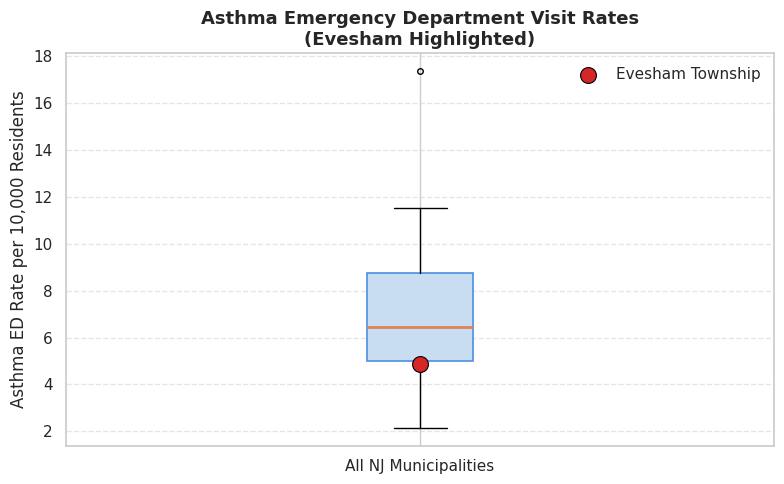

In [ ]:
plt.figure(figsize=(8,5))

# Use non-missing asthma values only
asthma_values = nj_muni_df[COL_ASTHMA].dropna()
#asthma_transformed = np.log(asthma_values)
asthma_transformed = np.sqrt(asthma_values)
#asthma_transformed = np.arcsin(np.sqrt(asthma_values/100))

# Calculate the transformed Evesham
#evesham_transformed = np.log1p(evesham_row[COL_No_Health_Insurance])
evesham_transformed = np.sqrt(evesham_row[COL_ASTHMA])
#evesham_transformed = np.arcsin(np.sqrt(evesham_row[COL_ASTHMA] / 100))


# Create boxplot
plt.boxplot(
    asthma_transformed,
    vert=True,
    patch_artist=True,
    showfliers=True,
    boxprops=dict(facecolor="#C9DDF2", edgecolor="#4A90E2", linewidth=1.2),
    medianprops=dict(linewidth=2),
    whiskerprops=dict(linewidth=1),
    capprops=dict(linewidth=1),
    flierprops=dict(marker='o', markersize=4, markerfacecolor='none')
)

# Overlay Evesham's value
plt.scatter(
    1,
    evesham_transformed,
    s=130,
    color="#D62728",
    edgecolor="black",
    linewidth=0.8,
    zorder=3,
    label="Evesham Township"
)

# Labels and title
plt.title(
    "Asthma Emergency Department Visit Rates\n(Evesham Highlighted)",
    fontsize=13,
    weight="bold"
)
plt.ylabel("Asthma ED Rate per 10,000 Residents")
plt.xticks([1], ["All NJ Municipalities"])

# Grid for readability
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Legend
plt.legend(frameon=False)

plt.tight_layout()
plt.show()


The boxplot for Asthma ED Visit Rates (square root transformed) shows that the distribution is now more normally distributed, with Evesham Township's rate falling within the lower quartile, indicating a relatively low asthma ED visit rate compared to other municipalities.

Histogram Showing the Distribution of Poverty

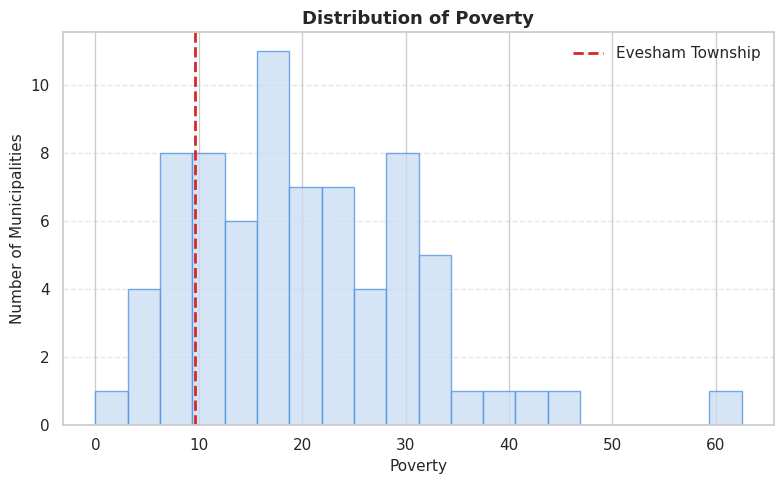

In [ ]:
# Prepare data (drop missing values)
poverty_values = nj_muni_df[COL_POVERTY].dropna()


plt.figure(figsize=(8,5))

# Histogram
plt.hist(
    poverty_values,
    bins=20,
    color = "#C9DDF2",
    edgecolor= "#4A90E2",
    alpha=0.75
)

#Evesham Overlay
plt.axvline(
    evesham_row[COL_POVERTY],
    linestyle="--",
    linewidth=2,
    label="Evesham Township",
    color="#D62728"
)

plt.legend(frameon=False)

# Titles and labels
plt.title(
    "Distribution of Poverty",
    fontsize=13,
    weight="bold"
)
plt.xlabel("Poverty", fontsize=11)
plt.ylabel("Number of Municipalities", fontsize=11)

# Grid for readability
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

The distribution of the poverty histogram is right-skewed, indicating that most municipalities have lower poverty rates. Evesham, highlighted in the graph, displays a low poverty rate compared to other municipalities.

Applying Square Root Transformation to Poverty Distribution

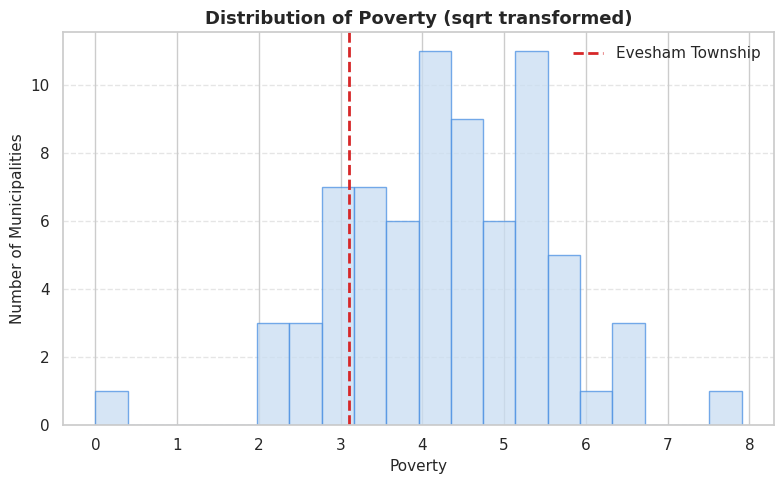

In [ ]:
# Prepare data (drop missing values)
poverty_values = nj_muni_df[COL_POVERTY].dropna()

#asthma_transformed = np.log(asthma_values)
poverty_transformed = np.sqrt(poverty_values)
#asthma_transformed = np.arcsin(np.sqrt(asthma_values/100))

# Calculate the transformed Evesham
#evesham_transformed = np.log1p(evesham_row[COL_No_Health_Insurance])
evesham_transformed = np.sqrt(evesham_row[COL_POVERTY])
#evesham_transformed = np.arcsin(np.sqrt(evesham_row[COL_ASTHMA] / 100))
plt.figure(figsize=(8,5))

# Histogram
plt.hist(
    poverty_transformed,
    bins=20,
    color = "#C9DDF2",
    edgecolor= "#4A90E2",
    alpha=0.75
)

#Evesham Overlay
plt.axvline(
    evesham_transformed,
    linestyle="--",
    linewidth=2,
    label="Evesham Township",
    color="#D62728"
)

plt.legend(frameon=False)

# Titles and labels
plt.title(
    "Distribution of Poverty (sqrt transformed)",
    fontsize=13,
    weight="bold"
)
plt.xlabel("Poverty", fontsize=11)
plt.ylabel("Number of Municipalities", fontsize=11)

# Grid for readability
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

The distribution of the poverty histogram is right-skewed, indicating that most municipalities have lower poverty rates. Evesham, highlighted in the graph, displays a low poverty rate compared to other municipalities.

Boxplot Showing Distribution of Poverty with Evesham Township Highlighted

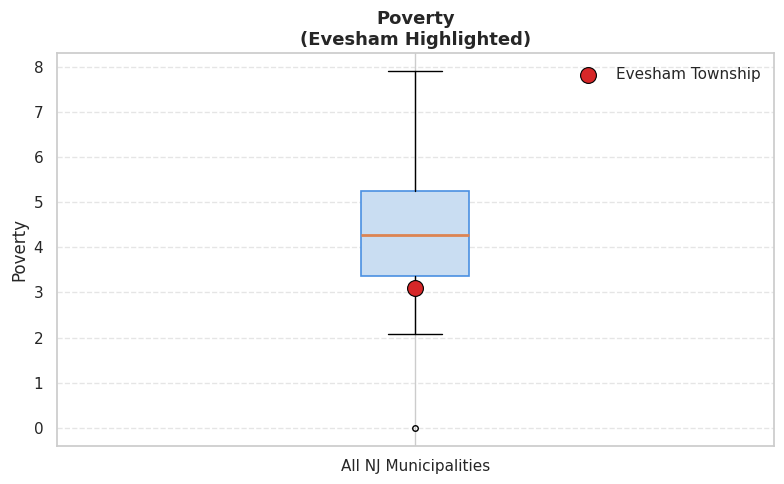

In [ ]:
plt.figure(figsize=(8,5))

# Use non-missing asthma values only
poverty_values = nj_muni_df[COL_POVERTY].dropna()

#asthma_transformed = np.log(asthma_values)
poverty_transformed = np.sqrt(poverty_values)
#asthma_transformed = np.arcsin(np.sqrt(asthma_values/100))

# Calculate the transformed Evesham
#evesham_transformed = np.log1p(evesham_row[COL_No_Health_Insurance])
evesham_transformed = np.sqrt(evesham_row[COL_POVERTY])
#evesham_transformed = np.arcsin(np.sqrt(evesham_row[COL_ASTHMA] / 100))

# Create boxplot
plt.boxplot(
    poverty_transformed,
    vert=True,
    patch_artist=True,
    showfliers=True,
    boxprops=dict(facecolor="#C9DDF2", edgecolor="#4A90E2", linewidth=1.2),
    medianprops=dict(linewidth=2),
    whiskerprops=dict(linewidth=1),
    capprops=dict(linewidth=1),
    flierprops=dict(marker='o', markersize=4, markerfacecolor='none')
)

# Overlay Evesham's value
plt.scatter(
    1,
    evesham_transformed,
    s=130,
    color="#D62728",
    edgecolor="black",
    linewidth=0.8,
    zorder=3,
    label="Evesham Township"
)

# Labels and title
plt.title(
    "Poverty\n(Evesham Highlighted)",
    fontsize=13,
    weight="bold"
)
plt.ylabel("Poverty")
plt.xticks([1], ["All NJ Municipalities"])

# Grid for readability
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Legend
plt.legend(frameon=False)

plt.tight_layout()
plt.show()

This boxplot shows the distribution of poverty rates across municipalities, with Evesham Township highlighted. Evesham’s poverty rate (around 3%) falls below the median of the distribution and within the lower quartile, indicating it has lower poverty levels than most peer municipalities. Overall, poverty rates vary moderately across areas, and the presence of a high outlier, indicating some municipalities have substantially higher poverty rates than the majority stretching the upper range and showing a slight right skew.

Minority %

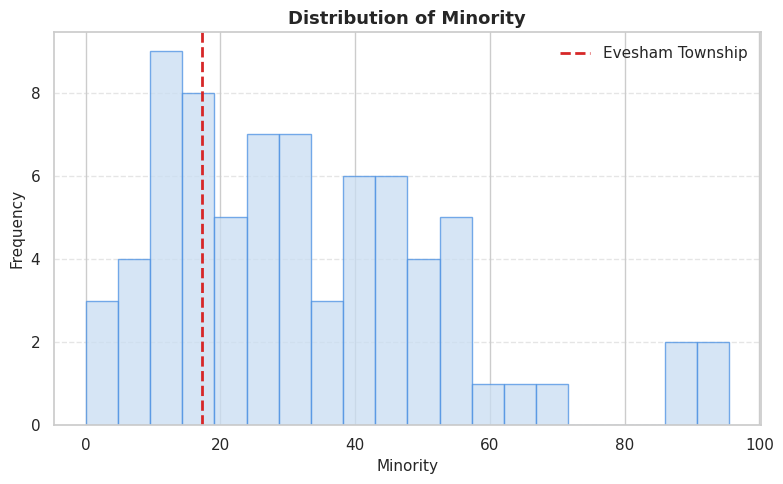

In [ ]:
# Prepare data (drop missing values)
minority_values = nj_muni_df[COL_MINORITY].dropna()

plt.figure(figsize=(8,5))

# Histogram
plt.hist(
    minority_values,
    bins=20,
    color = "#C9DDF2",
    edgecolor= "#4A90E2",
    alpha=0.75
)

#Evesham Overlay
plt.axvline(
    evesham_row[COL_MINORITY],
    linestyle="--",
    linewidth=2,
    label="Evesham Township",
    color="#D62728"
)

plt.legend(frameon=False)

# Titles and labels
plt.title(
    "Distribution of Minority",
    fontsize=13,
    weight="bold"
)
plt.xlabel("Minority", fontsize=11)
plt.ylabel("Frequency", fontsize=11)

# Grid for readability
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

The histogram showing the 'Distribution of Minority' percentage is right-skewed, indicating that many municipalities have lower minority percentages, while a few have significantly higher ones. Evesham Township, highlighted on the graph, falls within the lower portion of this distribution.

Applying sqrt transformation to minority distribution

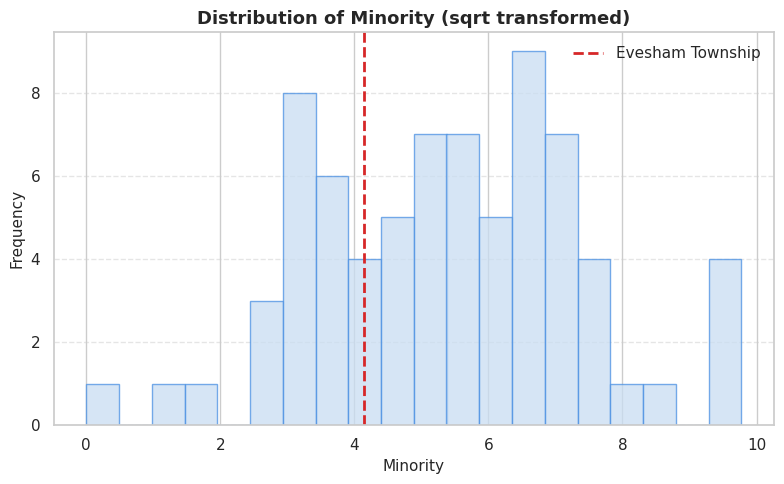

In [ ]:
# Prepare data (drop missing values)
minority_values = nj_muni_df[COL_MINORITY].dropna()

plt.figure(figsize=(8,5))
#asthma_transformed = np.log(asthma_values)
minority_transformed = np.sqrt(minority_values)
#asthma_transformed = np.arcsin(np.sqrt(asthma_values/100))

# Calculate the transformed Evesham
#evesham_transformed = np.log1p(evesham_row[COL_No_Health_Insurance])
evesham_transformed = np.sqrt(evesham_row[COL_MINORITY])
#evesham_transformed = np.arcsin(np.sqrt(evesham_row[COL_ASTHMA] / 100))

# Histogram
plt.hist(
    minority_transformed,
    bins=20,
    color = "#C9DDF2",
    edgecolor= "#4A90E2",
    alpha=0.75
)

#Evesham Overlay
plt.axvline(
    evesham_transformed,
    linestyle="--",
    linewidth=2,
    label="Evesham Township",
    color="#D62728"
)

plt.legend(frameon=False)

# Titles and labels
plt.title(
    "Distribution of Minority (sqrt transformed)",
    fontsize=13,
    weight="bold"
)
plt.xlabel("Minority", fontsize=11)
plt.ylabel("Frequency", fontsize=11)

# Grid for readability
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

The distribution of the minority histogram after transformation is less skewed and lot more normal. This indicates that the square root transformation was effective in making the data's distribution more symmetrical.

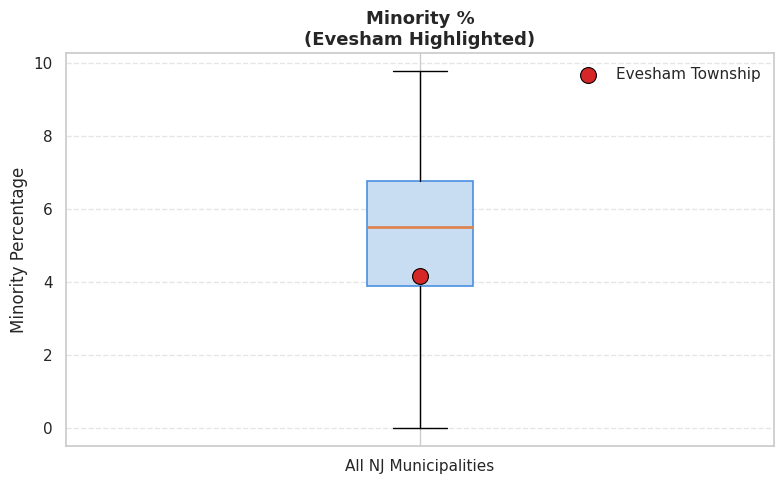

In [ ]:
plt.figure(figsize=(8,5))

# Use non-missing minority values only
minority_values = nj_muni_df[COL_MINORITY].dropna()
#asthma_transformed = np.log(asthma_values)
minority_transformed = np.sqrt(minority_values)
#asthma_transformed = np.arcsin(np.sqrt(asthma_values/100))

# Calculate the transformed Evesham
#evesham_transformed = np.log1p(evesham_row[COL_No_Health_Insurance])
evesham_transformed = np.sqrt(evesham_row[COL_MINORITY])
#evesham_transformed = np.arcsin(np.sqrt(evesham_row[COL_ASTHMA] / 100))

# Create boxplot
plt.boxplot(
    minority_transformed,
    vert=True,
    patch_artist=True,
    showfliers=True,
    boxprops=dict(facecolor="#C9DDF2", edgecolor="#4A90E2", linewidth=1.2),
    medianprops=dict(linewidth=2),
    whiskerprops=dict(linewidth=1),
    capprops=dict(linewidth=1),
    flierprops=dict(marker='o', markersize=4, markerfacecolor='none')
)

# Overlay Evesham's value
plt.scatter(
    1,
    evesham_transformed,
    s=130,
    color="#D62728",
    edgecolor="black",
    linewidth=0.8,
    zorder=3,
    label="Evesham Township"
)

# Labels and title
plt.title(
    "Minority %\n(Evesham Highlighted)",
    fontsize=13,
    weight="bold"
)
plt.ylabel("Minority Percentage")
plt.xticks([1], ["All NJ Municipalities"])

# Grid for readability
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Legend
plt.legend(frameon=False)

plt.tight_layout()
plt.show()

The boxplot for Minority Percentage shows a right-skewed distribution across municipalities, with a wide range of values and several outliers. Evesham Township's minority percentage (highlighted) falls within the lower quartile of this distribution, indicating a relatively low minority population compared to many other municipalities.

No Health Insurance

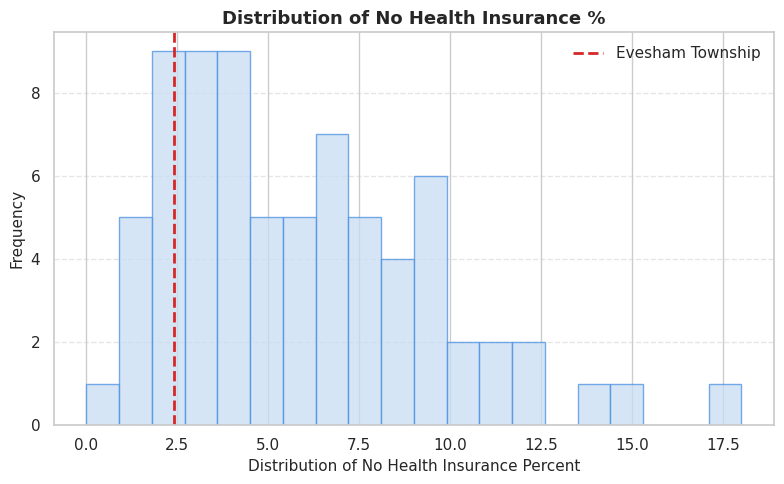

In [ ]:
# Prepare data (drop missing values)
No_health_insurance_values = nj_muni_df[COL_UNINSURED].dropna()

plt.figure(figsize=(8,5))

# Histogram
plt.hist(
    No_health_insurance_values,
    bins=20,
    color = "#C9DDF2",
    edgecolor= "#4A90E2",
    alpha=0.75
)

#Evesham Overlay
plt.axvline(
    evesham_row[COL_UNINSURED],
    linestyle="--",
    linewidth=2,
    label="Evesham Township",
    color="#D62728"
)

plt.legend(frameon=False)

# Titles and labels
plt.title(
    "Distribution of No Health Insurance %",
    fontsize=13,
    weight="bold"
)
plt.xlabel("Distribution of No Health Insurance Percent", fontsize=11)
plt.ylabel("Frequency", fontsize=11)

# Grid for readability
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


The distribution of the 'No Health Insurance Percent' histogram is right-skewed, indicating that most municipalities have lower percentages of uninsured residents. Evesham Township, highlighted in the graph, shows a relatively low percentage of uninsured residents compared to other municipalities.

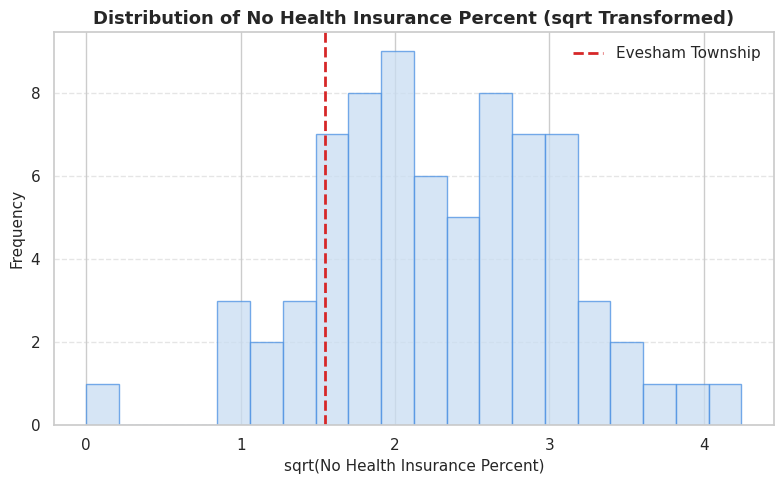

In [ ]:
import numpy as np
plt.figure(figsize=(8,5))

# Prepare data (drop missing values)
No_health_insurance_values = nj_muni_df[COL_UNINSURED].dropna()

# Apply sqrt transformation
No_health_insurance_transformed = np.sqrt(No_health_insurance_values)

# Calculate the transformed Evesham
evesham_transformed = np.sqrt(evesham_row[COL_UNINSURED])

# Histogram
plt.hist(
    No_health_insurance_transformed,
    bins=20,
    color = "#C9DDF2",
    edgecolor= "#4A90E2",
    alpha=0.75)

# Evesham Overlay
plt.axvline(
    evesham_transformed,
    linestyle="--",
    linewidth=2,
    label="Evesham Township",
    color="#D62728")

plt.legend(frameon=False)

# Titles and labels
plt.title(
    "Distribution of No Health Insurance Percent (sqrt Transformed)",
    fontsize=13,
    weight="bold"
)
plt.xlabel("sqrt(No Health Insurance Percent)", fontsize=11)
plt.ylabel("Frequency", fontsize=11)

# Grid for readability
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

This histogram shows the distribution of 'No Health Insurance Percent' after applying a square root transformation. The transformation has made the distribution less right-skewed and more symmetrical, which is generally preferred for statistical analysis. Evesham Township, marked by the red dashed line, is positioned on the lower end of this transformed distribution, indicating a comparatively low percentage of uninsured residents.



Box Plot of No Health Insurance %

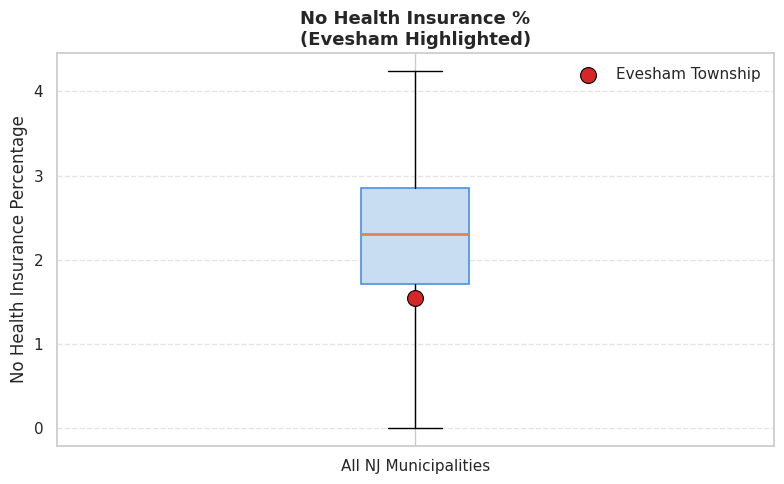

In [ ]:
plt.figure(figsize=(8,5))

# Use non-missing asthma values only
No_health_insurance_values = nj_muni_df[COL_UNINSURED].dropna()

No_health_insurance_transformed = np.sqrt(No_health_insurance_values)

# Calculate the transformed Evesham
evesham_transformed = np.sqrt(evesham_row[COL_UNINSURED])

# Create boxplot
plt.boxplot(
    No_health_insurance_transformed,
    vert=True,
    patch_artist=True,
    showfliers=True,
    boxprops=dict(facecolor="#C9DDF2", edgecolor="#4A90E2", linewidth=1.2),
    medianprops=dict(linewidth=2),
    whiskerprops=dict(linewidth=1),
    capprops=dict(linewidth=1),
    flierprops=dict(marker='o', markersize=4, markerfacecolor='none')
)

# Overlay Evesham's value
plt.scatter(
    1,
    evesham_transformed,
    s=130,
    color="#D62728",
    edgecolor="black",
    linewidth=0.8,
    zorder=3,
    label="Evesham Township"
)

# Labels and title
plt.title(
    "No Health Insurance %\n(Evesham Highlighted)",
    fontsize=13,
    weight="bold"
)
plt.ylabel("No Health Insurance Percentage")
plt.xticks([1], ["All NJ Municipalities"])

# Grid for readability
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Legend
plt.legend(frameon=False)

plt.tight_layout()
plt.show()

The boxplot for 'No Health Insurance' (square root transformed) shows a relatively compact distribution with Evesham Township's rate (highlighted) falling at the lower end, indicating a low percentage of uninsured residents compared to other municipalities. There are a few outliers representing municipalities with significantly higher rates.

Traffic

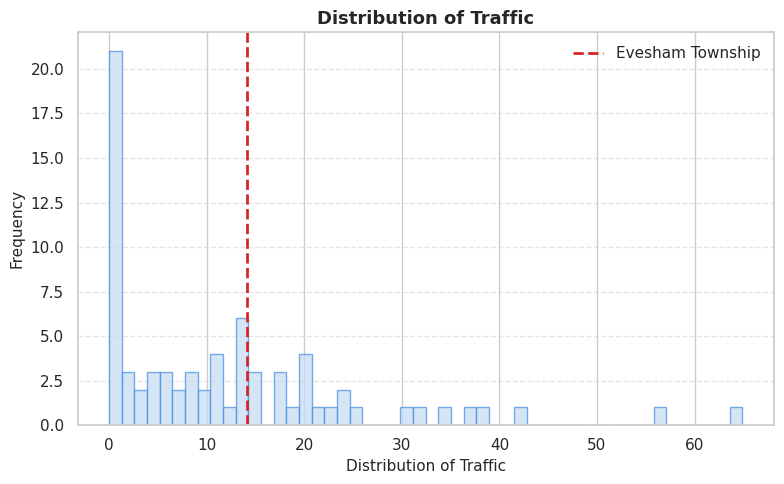

In [ ]:
# Prepare data (drop missing values)
traffic_values = nj_muni_df[COL_TRAFFIC].dropna()

plt.figure(figsize=(8,5))

# Histogram
plt.hist(
    traffic_values,
    bins=50,
    color = "#C9DDF2",
    edgecolor= "#4A90E2",
    alpha=0.75
)

#Evesham Overlay
plt.axvline(
    evesham_row[COL_TRAFFIC],
    linestyle="--",
    linewidth=2,
    label="Evesham Township",
    color="#D62728"
)

plt.legend(frameon=False)

# Titles and labels
plt.title(
    "Distribution of Traffic",
    fontsize=13,
    weight="bold"
)
plt.xlabel("Distribution of Traffic", fontsize=11)
plt.ylabel("Frequency", fontsize=11)

# Grid for readability
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

The distribution of traffic is a zero-inflated distribution. This characteristic suggests that a significant number of municipalities have zero or very low traffic exposure, making this variable less suitable for direct analysis without specialized handling.



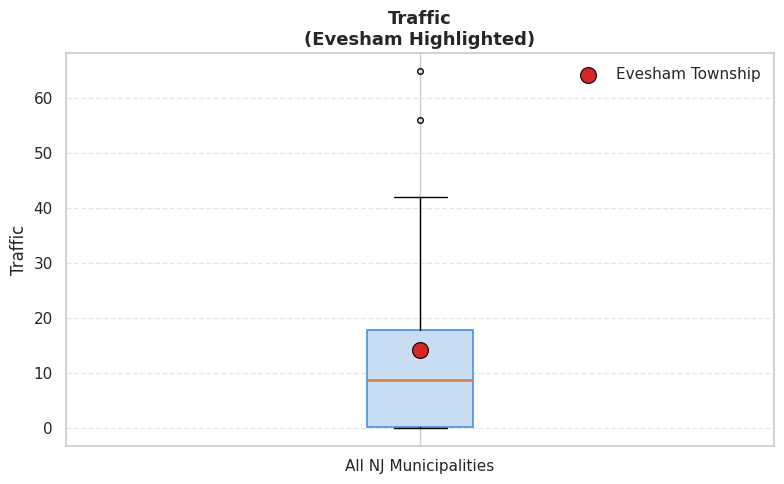

In [ ]:
plt.figure(figsize=(8,5))

# Use non-missing asthma values only
traffic_values = nj_muni_df[COL_TRAFFIC].dropna()

# Create boxplot
plt.boxplot(
    traffic_values,
    vert=True,
    patch_artist=True,
    showfliers=True,
    boxprops=dict(facecolor="#C9DDF2", edgecolor="#4A90E2", linewidth=1.2),
    medianprops=dict(linewidth=2),
    whiskerprops=dict(linewidth=1),
    capprops=dict(linewidth=1),
    flierprops=dict(marker='o', markersize=4, markerfacecolor='none')
)

# Overlay Evesham's value
plt.scatter(
    1,
    evesham_row[COL_TRAFFIC],
    s=130,
    color="#D62728",
    edgecolor="black",
    linewidth=0.8,
    zorder=3,
    label="Evesham Township"
)

# Labels and title
plt.title(
    "Traffic\n(Evesham Highlighted)",
    fontsize=13,
    weight="bold"
)
plt.ylabel("Traffic")
plt.xticks([1], ["All NJ Municipalities"])

# Grid for readability
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Legend
plt.legend(frameon=False)

plt.tight_layout()
plt.show()

This boxplot shows the distribution of 'Traffic' (percentage living near heavy traffic), which is a zero-inflated variable meaning many municipalities have zero traffic exposure. Evesham Township (highlighted) shows a relatively moderate traffic exposure compared to the bulk of municipalities, which have very low or zero traffic, while there are a few outliers with significantly higher traffic.

Air Cancer Risk

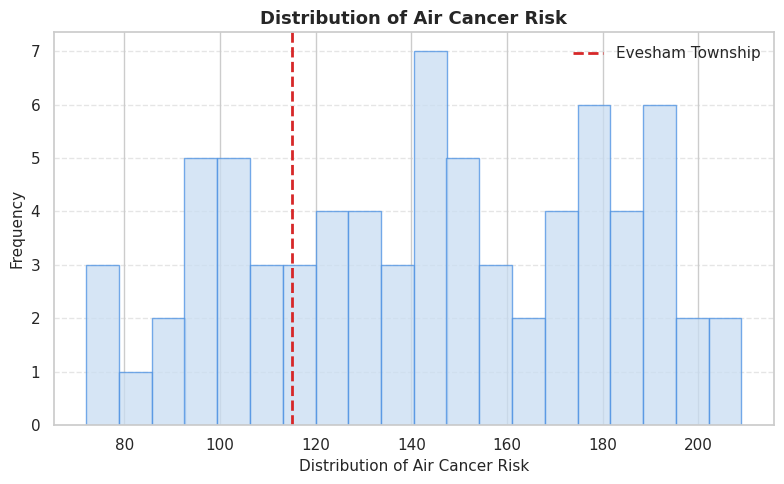

In [ ]:
# Prepare data (drop missing values)
air_cancer_risk_values = nj_muni_df[COL_Air_Cancer_Risk].dropna()

plt.figure(figsize=(8,5))

# Histogram
plt.hist(
    air_cancer_risk_values,
    bins=20,
    color = "#C9DDF2",
    edgecolor= "#4A90E2",
    alpha=0.75
)

#Evesham Overlay
plt.axvline(
    evesham_row[COL_Air_Cancer_Risk],
    linestyle="--",
    linewidth=2,
    label="Evesham Township",
    color="#D62728"
)

plt.legend(frameon=False)

# Titles and labels
plt.title(
    "Distribution of Air Cancer Risk",
    fontsize=13,
    weight="bold"
)
plt.xlabel("Distribution of Air Cancer Risk", fontsize=11)
plt.ylabel("Frequency", fontsize=11)

# Grid for readability
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

This histogram shows the distribution of 'Air Cancer Risk' across municipalities. While the exact shape can vary, environmental risk factors often exhibit some degree of skewness. Evesham Township's position, indicated by the red line, would show where its Air Cancer Risk falls relative to other municipalities, whether it's on the lower, middle, or higher end of this distribution.

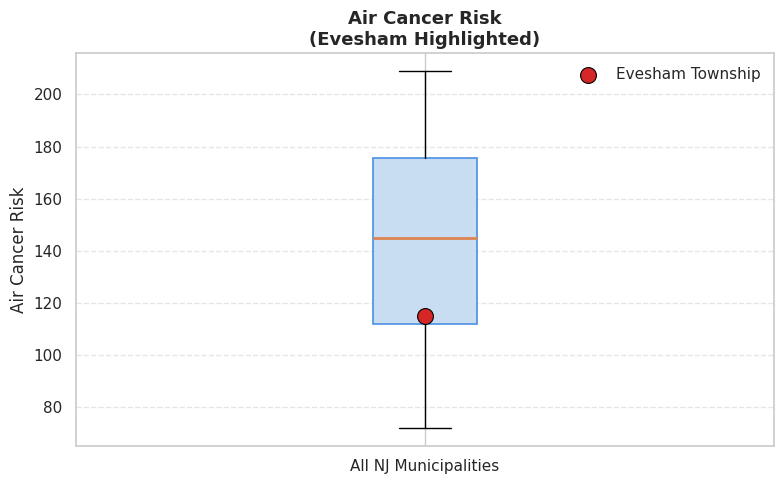

In [ ]:
plt.figure(figsize=(8,5))

# Use non-missing asthma values only
air_cancer_risk_values = nj_muni_df[COL_Air_Cancer_Risk].dropna()

# Create boxplot
plt.boxplot(
    air_cancer_risk_values,
    vert=True,
    patch_artist=True,
    showfliers=True,
    boxprops=dict(facecolor="#C9DDF2", edgecolor="#4A90E2", linewidth=1.2),
    medianprops=dict(linewidth=2),
    whiskerprops=dict(linewidth=1),
    capprops=dict(linewidth=1),
    flierprops=dict(marker='o', markersize=4, markerfacecolor='none')
)

# Overlay Evesham's value
plt.scatter(
    1,
    evesham_row[COL_Air_Cancer_Risk],
    s=130,
    color="#D62728",
    edgecolor="black",
    linewidth=0.8,
    zorder=3,
    label="Evesham Township"
)

# Labels and title
plt.title(
    "Air Cancer Risk\n(Evesham Highlighted)",
    fontsize=13,
    weight="bold"
)
plt.ylabel("Air Cancer Risk")
plt.xticks([1], ["All NJ Municipalities"])

# Grid for readability
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Legend
plt.legend(frameon=False)

plt.tight_layout()
plt.show()

This boxplot shows the distribution of 'Air Cancer Risk' across all municipalities. Evesham Township's specific Air Cancer Risk value, highlighted by the red dot, is positioned relative to the overall spread of risks, indicating whether it's lower, similar to, or higher than the majority of other municipalities. It helps to visualize the median risk, the spread of the middle 50% of municipalities, and any outliers with exceptionally high or low risks.



Air Non Cancer

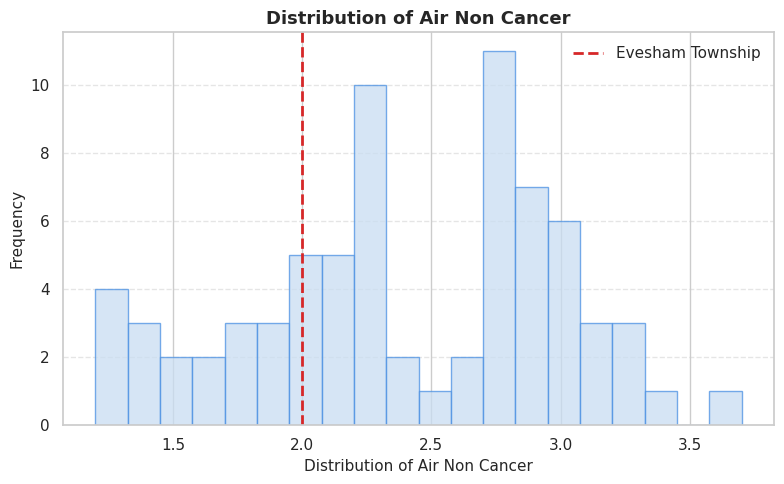

In [ ]:
# Prepare data (drop missing values)
air_non_cancer_values = nj_muni_df[COL_Air_Non_Cancer].dropna()

plt.figure(figsize=(8,5))

# Histogram
plt.hist(
    air_non_cancer_values,
    bins=20,
    color = "#C9DDF2",
    edgecolor= "#4A90E2",
    alpha=0.75
)

#Evesham Overlay
plt.axvline(
    evesham_row[COL_Air_Non_Cancer],
    linestyle="--",
    linewidth=2,
    label="Evesham Township",
    color="#D62728"
)

plt.legend(frameon=False)

# Titles and labels
plt.title(
    "Distribution of Air Non Cancer",
    fontsize=13,
    weight="bold"
)
plt.xlabel("Distribution of Air Non Cancer", fontsize=11)
plt.ylabel("Frequency", fontsize=11)

# Grid for readability
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

This histogram shows the distribution of 'Air Cancer Risk' across municipalities. While the exact shape can vary, environmental risk factors often exhibit some degree of skewness. Evesham Township's position, indicated by the red line, would show where its Air Cancer Risk falls relative to other municipalities, whether it's on the lower, middle, or higher end of this distribution.



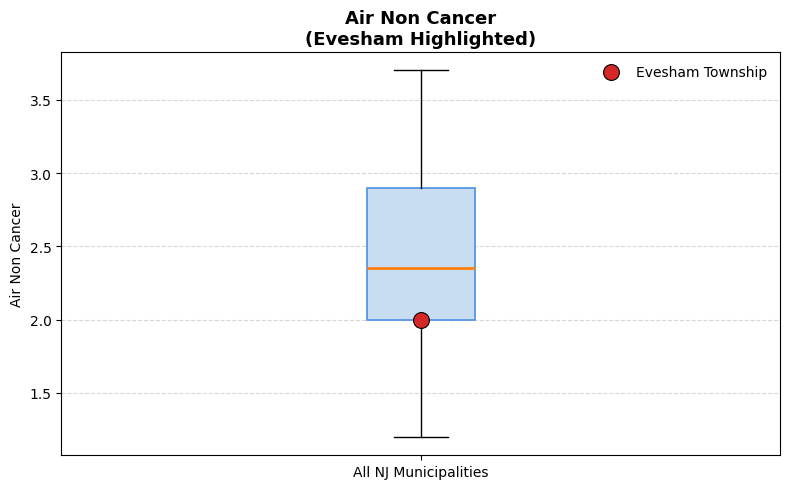

In [ ]:
plt.figure(figsize=(8,5))

# Use non-missing asthma values only
air_non_cancer_values = nj_muni_df[COL_Air_Non_Cancer].dropna()

# Create boxplot
plt.boxplot(
    air_non_cancer_values,
    vert=True,
    patch_artist=True,
    showfliers=True,
    boxprops=dict(facecolor="#C9DDF2", edgecolor="#4A90E2", linewidth=1.2),
    medianprops=dict(linewidth=2),
    whiskerprops=dict(linewidth=1),
    capprops=dict(linewidth=1),
    flierprops=dict(marker='o', markersize=4, markerfacecolor='none')
)

# Overlay Evesham's value
plt.scatter(
    1,
    evesham_row[COL_Air_Non_Cancer],
    s=130,
    color="#D62728",
    edgecolor="black",
    linewidth=0.8,
    zorder=3,
    label="Evesham Township"
)

# Labels and title
plt.title(
    "Air Non Cancer\n(Evesham Highlighted)",
    fontsize=13,
    weight="bold"
)
plt.ylabel("Air Non Cancer")
plt.xticks([1], ["All NJ Municipalities"])

# Grid for readability
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Legend
plt.legend(frameon=False)

plt.tight_layout()
plt.show()

This boxplot displays the distribution of 'Air Non Cancer' values across all municipalities. The red dot highlights Evesham Township's specific 'Air Non Cancer' value, allowing for a quick visual comparison of its risk level against the overall range, median, and interquartile range of all other municipalities.



Air Quality Index

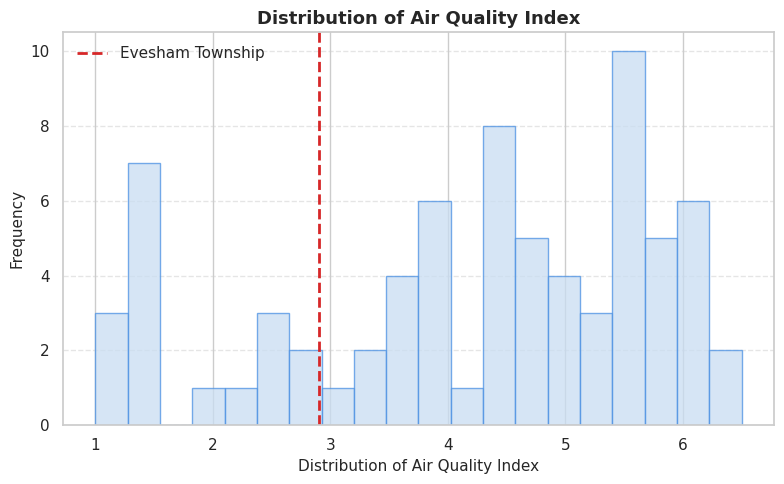

In [ ]:
# Prepare data (drop missing values)
air_quality_index_values = nj_muni_df[COL_Air_Quality_Index].dropna()

plt.figure(figsize=(8,5))

# Histogram
plt.hist(
    air_quality_index_values,
    bins=20,
    color = "#C9DDF2",
    edgecolor= "#4A90E2",
    alpha=0.75
)

#Evesham Overlay
plt.axvline(
    evesham_row[COL_Air_Quality_Index],
    linestyle="--",
    linewidth=2,
    label="Evesham Township",
    color="#D62728"
)

plt.legend(frameon=False)

# Titles and labels
plt.title(
    "Distribution of Air Quality Index",
    fontsize=13,
    weight="bold"
)
plt.xlabel("Distribution of Air Quality Index", fontsize=11)
plt.ylabel("Frequency", fontsize=11)

# Grid for readability
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

The histogram for 'Distribution of Air Quality Index' reveals a right-skewed distribution, which indicates that the majority of municipalities have lower Air Quality Index (AQI) values, corresponding to better air quality. The red dashed line representing Evesham Township is positioned at the lower end of this distribution, suggesting that Evesham experiences relatively better air quality compared to most other municipalities in the dataset.

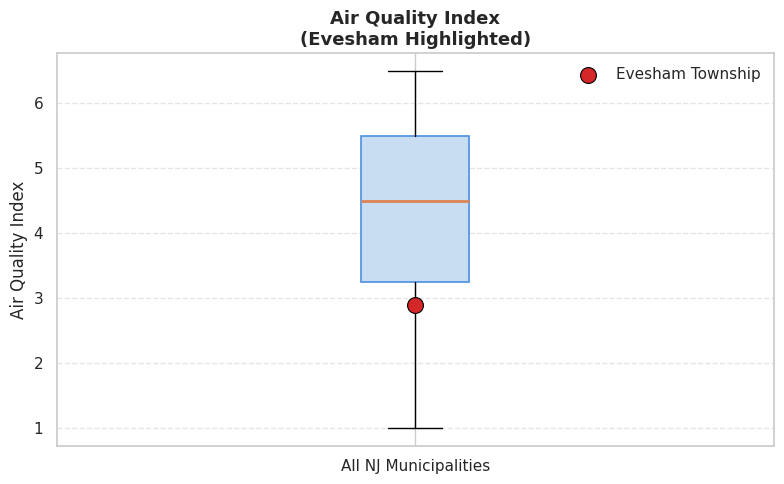

In [ ]:
plt.figure(figsize=(8,5))

# Use non-missing asthma values only
air_quality_index_values = nj_muni_df[COL_Air_Quality_Index].dropna()

# Create boxplot
plt.boxplot(
    air_quality_index_values,
    vert=True,
    patch_artist=True,
    showfliers=True,
    boxprops=dict(facecolor="#C9DDF2", edgecolor="#4A90E2", linewidth=1.2),
    medianprops=dict(linewidth=2),
    whiskerprops=dict(linewidth=1),
    capprops=dict(linewidth=1),
    flierprops=dict(marker='o', markersize=4, markerfacecolor='none')
)

# Overlay Evesham's value
plt.scatter(
    1,
    evesham_row[COL_Air_Quality_Index],
    s=130,
    color="#D62728",
    edgecolor="black",
    linewidth=0.8,
    zorder=3,
    label="Evesham Township"
)

# Labels and title
plt.title(
    "Air Quality Index\n(Evesham Highlighted)",
    fontsize=13,
    weight="bold"
)
plt.ylabel("Air Quality Index")
plt.xticks([1], ["All NJ Municipalities"])

# Grid for readability
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Legend
plt.legend(frameon=False)

plt.tight_layout()
plt.show()

This boxplot displays the distribution of 'Air Quality Index' across all municipalities. The red dot highlights Evesham Township's specific 'Air Quality Index' value. As shown in the plot, Evesham Township's Air Quality Index falls within the lower quartile, indicating relatively good air quality compared to many other municipalities, most of which have higher index values.

Flooding

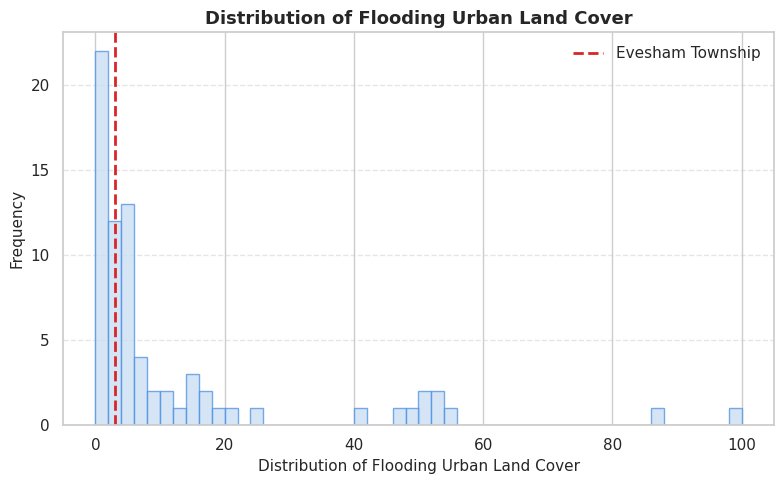

In [ ]:
# Prepare data (drop missing values)
flooding_urban_land_cover_values = nj_muni_df[COL_Flooding_Urban_Land_Cover].dropna()

plt.figure(figsize=(8,5))

# Histogram
plt.hist(
    flooding_urban_land_cover_values,
    bins=50,
    color = "#C9DDF2",
    edgecolor= "#4A90E2",
    alpha=0.75
)

#Evesham Overlay
plt.axvline(
    evesham_row[COL_Flooding_Urban_Land_Cover],
    linestyle="--",
    linewidth=2,
    label="Evesham Township",
    color="#D62728"
)

plt.legend(frameon=False)

# Titles and labels
plt.title(
    "Distribution of Flooding Urban Land Cover",
    fontsize=13,
    weight="bold"
)
plt.xlabel("Distribution of Flooding Urban Land Cover", fontsize=11)
plt.ylabel("Frequency", fontsize=11)

# Grid for readability
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

As we can see, the distribution of Flooding Urban Land Cover is a zero inflated distribution. So, this variable is not good for this analysis and it will not be used.

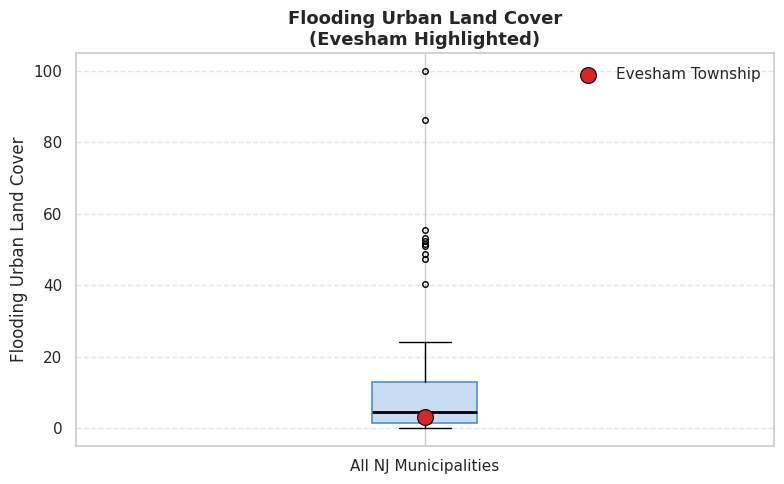

In [ ]:
plt.figure(figsize=(8,5))

# Use non-missing asthma values only
flooding_urban_land_cover_values = nj_muni_df[COL_Flooding_Urban_Land_Cover].dropna()

# Create boxplot
plt.boxplot(
    flooding_urban_land_cover_values,
    vert=True,
    patch_artist=True,
    showfliers=True,
    boxprops=dict(facecolor="#C9DDF2", edgecolor="#4A90E2", linewidth=1.2),
    medianprops=dict(color="black", linewidth=2),
    whiskerprops=dict(linewidth=1),
    capprops=dict(linewidth=1),
    flierprops=dict(marker='o', markersize=4, markerfacecolor='none')
)

# Overlay Evesham's value
plt.scatter(
    1,
    evesham_row[COL_Flooding_Urban_Land_Cover],
    s=130,
    color="#D62728",
    edgecolor="black",
    linewidth=0.8,
    zorder=3,
    label="Evesham Township"
)

# Labels and title
plt.title(
    "Flooding Urban Land Cover\n(Evesham Highlighted)",
    fontsize=13,
    weight="bold"
)
plt.ylabel("Flooding Urban Land Cover")
plt.xticks([1], ["All NJ Municipalities"])

# Grid for readability
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Legend
plt.legend(frameon=False)

plt.tight_layout()
plt.show()

This boxplot displays the distribution of 'Flooding Urban Land Cover' across all municipalities. The red dot highlights Evesham Township's value. Given the zero-inflated nature of this variable (as seen in the histogram), the boxplot likely shows a compressed distribution with many outliers. Evesham Township's position indicates its specific percentage of urban land cover susceptible to flooding relative to the rest of the municipalities.

Assign sqrt transformed to the df

In [ ]:
#Remove rows with NA values from df
df = df.dropna()
# Add square root transformed columns to the dataframe
df['Asthma_%_sqrt'] = np.sqrt(df[COL_ASTHMA])
df['Minority_%_sqrt'] = np.sqrt(df[COL_MINORITY])
df['Poverty_%_Under_2x_sqrt'] = np.sqrt(df[COL_POVERTY])
df['No_Health_Insurance_%_sqrt'] = np.sqrt(df[COL_UNINSURED])

# Check skewness before and after transformation

original_skew = stats.skew(df[COL_ASTHMA])
transformed_skew = stats.skew(df['Asthma_%_sqrt'])
print(f"Original skewness Asthma: {original_skew:.2f}")
print(f"Transformed skewness Asthma: {transformed_skew:.2f}")

original_skew = stats.skew(df[COL_MINORITY])
transformed_skew = stats.skew(df['Minority_%_sqrt'])
print(f"Original skewness Minority: {original_skew:.2f}")
print(f"Transformed skewness Minority: {transformed_skew:.2f}")

original_skew = stats.skew(df[COL_POVERTY])
transformed_skew = stats.skew(df['Poverty_%_Under_2x_sqrt'])
print(f"Original skewness Poverty: {original_skew:.2f}")
print(f"Transformed skewness Poverty: {transformed_skew:.2f}")

original_skew = stats.skew(df[COL_UNINSURED])
transformed_skew = stats.skew(df['No_Health_Insurance_%_sqrt'])
print(f"Original skewness No Health Insurance: {original_skew:.2f}")
print(f"Transformed skewness No Health Insurance: {transformed_skew:.2f}")

df.head()

Original skewness Asthma: 3.08
Transformed skewness Asthma: 1.22
Original skewness Minority: 1.06
Transformed skewness Minority: 0.32
Original skewness Poverty: 1.37
Transformed skewness Poverty: 0.54
Original skewness No Health Insurance: 1.29
Transformed skewness No Health Insurance: 0.54


,State_Municipality_County,State_Municipality_County_Level_Type,County,Summary_Report_URL,Total_Population,Poverty_%_Under_2x,Minority_%,No_Health_Insurance_%,Traffic_%_1000ft_Heavy,Asthma_ED_Rate_10k,Air_Cancer_Risk,Air_Non_Cancer,Air_Quality_Index,Flooding_Urban_Land_Cover,Asthma_%_sqrt,Minority_%_sqrt,Poverty_%_Under_2x_sqrt,No_Health_Insurance_%_sqrt
4,Bordentown City,Municipality,Burlington,https://www.nj.gov/health/hcpnj/documents/coun...,3808,16.4,23.0,2.9,13.7,92.4,170,2.3,3.0,4.5,9.612492,4.795832,4.049691,1.702939
5,Bordentown Township,Municipality,Burlington,https://www.nj.gov/health/hcpnj/documents/coun...,12103,17.3,25.5,5.2,20.7,17.2,164,2.2,4.6,2.6,4.147288,5.049752,4.159327,2.280351
7,Burlington Township,Municipality,Burlington,https://www.nj.gov/health/hcpnj/documents/coun...,22600,16.9,55.1,4.7,13.5,4.6,145,2.7,6.0,14.0,2.144761,7.422937,4.110961,2.167948
9,Cinnaminson Township,Municipality,Burlington,https://www.nj.gov/health/hcpnj/documents/coun...,16429,9.2,14.5,3.8,11.2,14.8,161,3.1,4.8,14.8,3.847077,3.807887,3.033150,1.949359
10,Delanco Township,Municipality,Burlington,https://www.nj.gov/health/hcpnj/documents/coun...,4448,19.0,30.0,6.6,0.0,32.4,154,2.9,5.8,48.8,5.692100,5.477226,4.358899,2.569047


In [ ]:
# Isolate the specific row for Evesham Township, ensuring it's a municipality-level record.
evesham_row = df[
    (df[COL_GEO] == "Evesham Township") &
    (df[COL_LEVEL] == "Municipality")
].iloc[0]

# Create a DataFrame containing on municipality-level data for New Jersey.
nj_muni_df = df[df[COL_LEVEL] == "Municipality"].copy()

# Filter the New Jersey municipalities to get only those in Burlington County.
burlington_df = nj_muni_df[nj_muni_df[COL_COUNTY] == "Burlington"]

# Filter the New Jersey municipalities to get only those in Camden County.
camden_df = nj_muni_df[nj_muni_df[COL_COUNTY] == "Camden"]

Finding Missing Values

In [ ]:
# Check for missing values
missing_values = nj_muni_df.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 State_Municipality_County               0
State_Municipality_County_Level_Type    0
County                                  0
Summary_Report_URL                      0
Total_Population                        0
Poverty_%_Under_2x                      0
Minority_%                              0
No_Health_Insurance_%                   0
Traffic_%_1000ft_Heavy                  0
Asthma_ED_Rate_10k                      0
Air_Cancer_Risk                         0
Air_Non_Cancer                          0
Air_Quality_Index                       0
Flooding_Urban_Land_Cover               0
Asthma_%_sqrt                           0
Minority_%_sqrt                         0
Poverty_%_Under_2x_sqrt                 0
No_Health_Insurance_%_sqrt              0
dtype: int64


### **Multivariate Analysis**

Reusable scatterplot function

In [ ]:
def county_scatterplot(
    x_col,
    y_col,
    title,
    x_label,
    y_label
):
    # Prepare clean data
    scatter_df = nj_muni_df[[x_col, y_col, "County"]].dropna()

    plt.figure(figsize=(8,5))

    # Burlington County
    burlington_plot_df = scatter_df[scatter_df["County"] == "Burlington"]
    plt.scatter(
        burlington_plot_df[x_col],
        burlington_plot_df[y_col],
        s=40,
        alpha=0.6,
        label="Burlington County"
    )

    # Camden County
    camden_plot_df = scatter_df[scatter_df["County"] == "Camden"]
    plt.scatter(
        camden_plot_df[x_col],
        camden_plot_df[y_col],
        s=40,
        alpha=0.6,
        label="Camden County"
    )

    # Overall trend line
    m, b = np.polyfit(
        scatter_df[x_col],
        scatter_df[y_col],
        1
    )

    x_vals = np.linspace(
        scatter_df[x_col].min(),
        scatter_df[x_col].max(),
        100
    )

    plt.plot(
        x_vals,
        m * x_vals + b,
        linestyle="--",
        linewidth=2,
        label="Overall trend"
    )

    # Highlight Evesham Township
    plt.scatter(
        evesham_row[x_col],
        evesham_row[y_col],
        s=150,
        color="#D62728",
        edgecolor="black",
        linewidth=0.8,
        zorder=3,
        label="Evesham Township"
    )

    # Titles and labels
    plt.title(title, fontsize=13, weight="bold")
    plt.xlabel(x_label, fontsize=11)
    plt.ylabel(y_label, fontsize=11)

    # Grid and legend
    plt.grid(linestyle="--", alpha=0.4)
    plt.legend(frameon=False)

    plt.tight_layout()
    plt.show()

Asthma vs Poverty

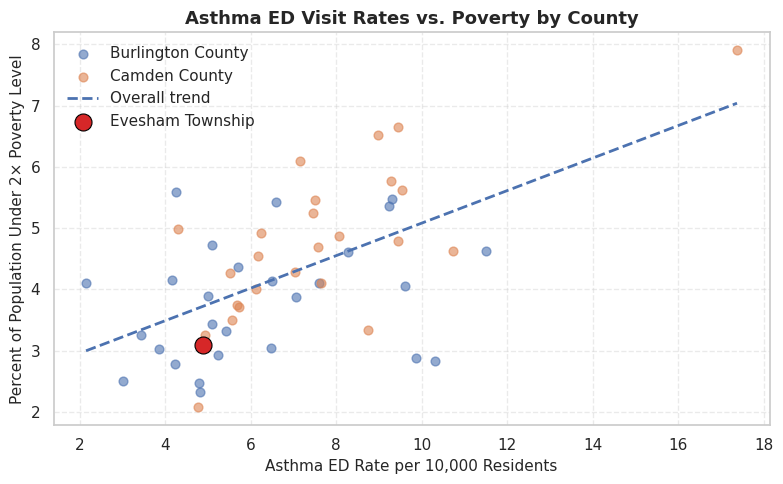

In [ ]:
county_scatterplot(
    #x_col=COL_ASTHMA,
    x_col='Asthma_%_sqrt',
    #y_col=COL_POVERTY,
    y_col='Poverty_%_Under_2x_sqrt',
    title="Asthma ED Visit Rates vs. Poverty by County",
    x_label="Asthma ED Rate per 10,000 Residents",
    y_label="Percent of Population Under 2× Poverty Level"
)

This scatterplot visualizes the relationship between 'Asthma ED Visit Rates' and 'Poverty (% Under 2x Poverty Level)'. The overall trend line shows a weak positive correlation, suggesting that municipalities with higher poverty rates tend to have slightly higher asthma ED visit rates. Evesham Township (highlighted in red) is positioned in the lower-left quadrant, indicating both a lower asthma ED rate and a lower poverty rate compared to most municipalities in Burlington and Camden Counties.

Asthma vs Traffic

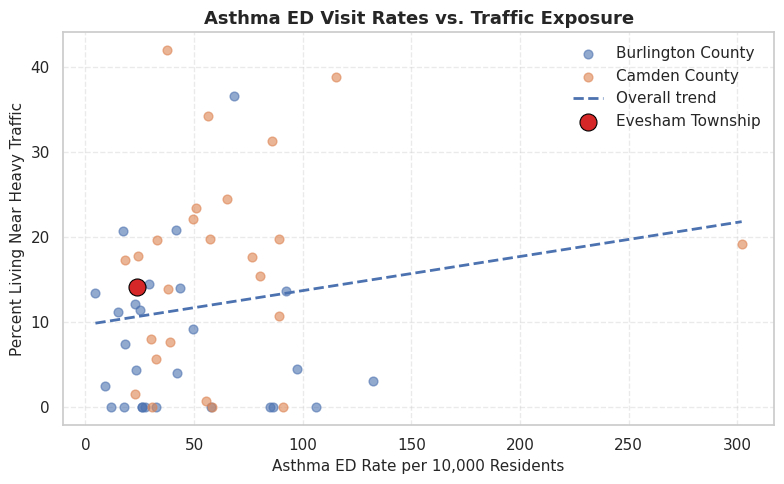

In [ ]:
county_scatterplot(
    x_col=COL_ASTHMA,
    y_col=COL_TRAFFIC,
    title="Asthma ED Visit Rates vs. Traffic Exposure",
    x_label="Asthma ED Rate per 10,000 Residents",
    y_label="Percent Living Near Heavy Traffic"
)


This scatterplot visualizes the relationship between 'Asthma ED Visit Rates' and 'Poverty (% Under 2x Poverty Level)'. The overall trend line shows a weak positive correlation, suggesting that municipalities with higher poverty rates tend to have slightly higher asthma ED visit rates. Evesham Township (highlighted in red) is positioned in the lower-left quadrant, indicating both a lower asthma ED rate and a lower poverty rate compared to most municipalities in Burlington and Camden Counties.

Asthma vs Minority

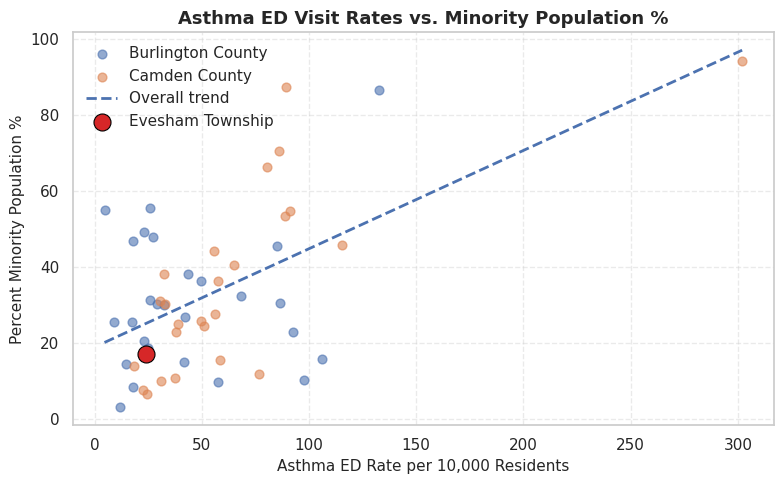

In [ ]:
county_scatterplot(
    x_col=COL_ASTHMA,
    y_col=COL_MINORITY,
    title="Asthma ED Visit Rates vs. Minority Population %",
    x_label="Asthma ED Rate per 10,000 Residents",
    y_label="Percent Minority Population %"
)


This scatterplot illustrates the relationship between 'Asthma ED Visit Rates' and 'Minority Population %'. There appears to be a weak positive correlation, with municipalities having higher minority populations tending to show slightly higher asthma ED rates. However, the data points are quite scattered. Evesham Township (highlighted in red) is located in the lower-left portion of the plot, indicating both a lower minority population percentage and a lower asthma ED visit rate compared to many other municipalities in the region.

Asthma vs No Health Insurance

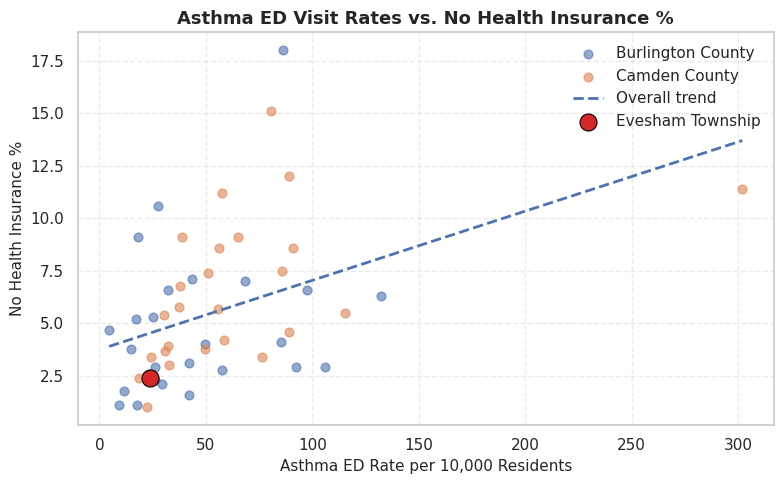

In [ ]:
county_scatterplot(
    x_col=COL_ASTHMA,
    y_col=COL_UNINSURED,
    title="Asthma ED Visit Rates vs. No Health Insurance %",
    x_label="Asthma ED Rate per 10,000 Residents",
    y_label="No Health Insurance %"
)


This scatterplot shows the relationship between 'Asthma ED Visit Rates' and 'No Health Insurance %'. A moderate positive correlation is visible, suggesting that municipalities with higher percentages of uninsured residents tend to experience higher asthma ED visit rates. Evesham Township (highlighted in red) is situated in the lower-left area of the plot, indicating both a lower percentage of uninsured residents and a lower asthma ED visit rate, aligning with the general trend.

Asthma vs Traffic

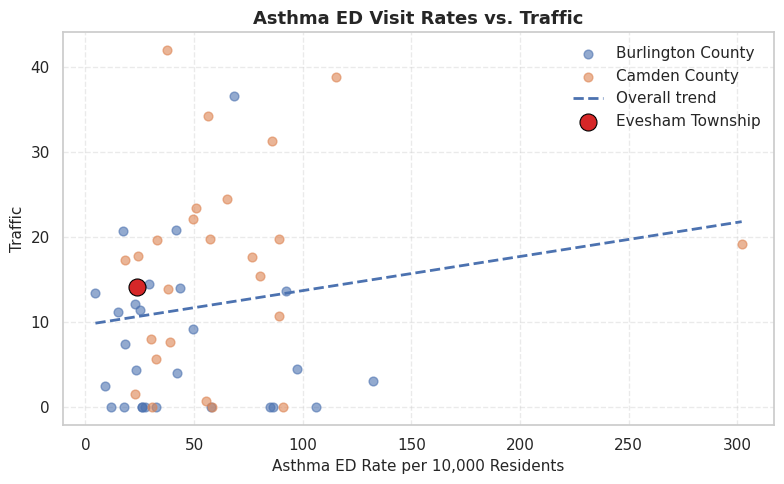

In [ ]:
county_scatterplot(
    x_col=COL_ASTHMA,
    y_col=COL_TRAFFIC,
    title="Asthma ED Visit Rates vs. Traffic",
    x_label="Asthma ED Rate per 10,000 Residents",
    y_label="Traffic"
)


This scatterplot displays Asthma ED Visit Rates vs. Traffic. It shows a very weak positive correlation between asthma ED rates and traffic exposure, with Evesham Township positioned in the lower-left, indicating low traffic exposure and a low asthma ED rate. Its presence reaffirms the earlier observation about the limited relationship between these two variables as measured in this dataset.

Asthma vs Air Cancer Risk

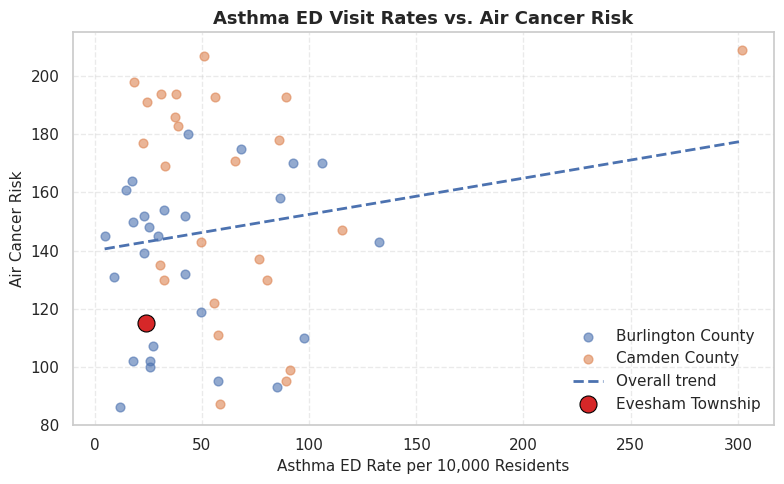

In [ ]:
county_scatterplot(
    x_col=COL_ASTHMA,
    y_col=COL_Air_Cancer_Risk,
    title="Asthma ED Visit Rates vs. Air Cancer Risk",
    x_label="Asthma ED Rate per 10,000 Residents",
    y_label="Air Cancer Risk"
)


This scatterplot illustrates the relationship between 'Asthma ED Visit Rates' and 'Air Cancer Risk'. The plot shows a very weak to negligible correlation. Evesham Township (highlighted in red) has a relatively low air cancer risk and a low asthma ED visit rate, placing it among municipalities with better environmental health outcomes for this specific metric. The overall trend line is nearly flat or slightly negative, suggesting no clear positive association, which might be counter-intuitive, or indicates the air cancer risk metric as defined does not strongly predict asthma ED rates.

Asthma vs Air Non Cancer

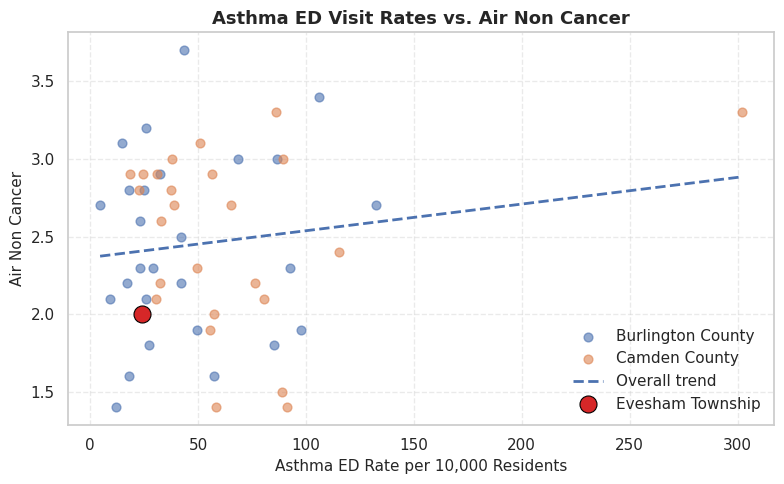

In [ ]:
county_scatterplot(
    x_col=COL_ASTHMA,
    y_col=COL_Air_Non_Cancer,
    title="Asthma ED Visit Rates vs. Air Non Cancer",
    x_label="Asthma ED Rate per 10,000 Residents",
    y_label="Air Non Cancer"
)


This scatterplot displays the relationship between 'Asthma ED Visit Rates' and 'Air Non Cancer' risk. Similar to air cancer risk, there is a very weak to negligible correlation, with data points widely dispersed. Evesham Township (highlighted in red) exhibits a relatively low air non-cancer risk and a low asthma ED visit rate, suggesting it has favorable environmental conditions in this regard. The lack of a clear trend indicates that this specific air non-cancer risk metric is not a strong predictor of asthma ED rates in this dataset.

Asthma vs Air Quality Index

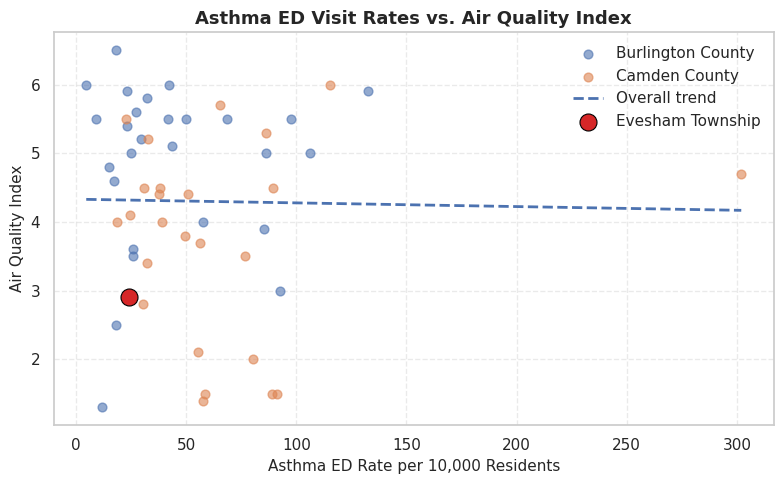

In [ ]:
county_scatterplot(
    x_col=COL_ASTHMA,
    y_col=COL_Air_Quality_Index,
    title="Asthma ED Visit Rates vs. Air Quality Index",
    x_label="Asthma ED Rate per 10,000 Residents",
    y_label="Air Quality Index"
)


This scatterplot shows the relationship between Asthma ED Visit Rates (x-axis) and Air Quality Index (y-axis) across different locations in Burlington County and Camden County.
What the Air Quality Index Column Measures
The "Air Quality Index (AQI) Days AQI above 100 (3 yr Avg)" represents:

The average number of days per year (over a 3-year period) when the Air Quality Index exceeded 100
An AQI above 100 is considered "Unhealthy for Sensitive Groups" according to EPA standards

What the Graph Shows

Weak negative correlation: The dashed trend line slopes slightly downward, suggesting areas with more poor air quality days have slightly lower asthma ED rates (though this is counterintuitive and the correlation is very weak)
Wide scatter: The data points are quite dispersed, indicating air quality (as measured by days over AQI 100) is not a strong predictor of asthma ED visits
Evesham Township (the large red circle at approximately 25 ED visits, 2.9 AQI days) sits well below the trend line with relatively low values for both metrics

Key Insight
The weak relationship suggests that while poor air quality days might contribute to asthma, other factors (poverty, insurance coverage, minority status) appear to have much stronger associations with asthma ED visit rates, as shown in the other graphs.

Asthma vs Flooding

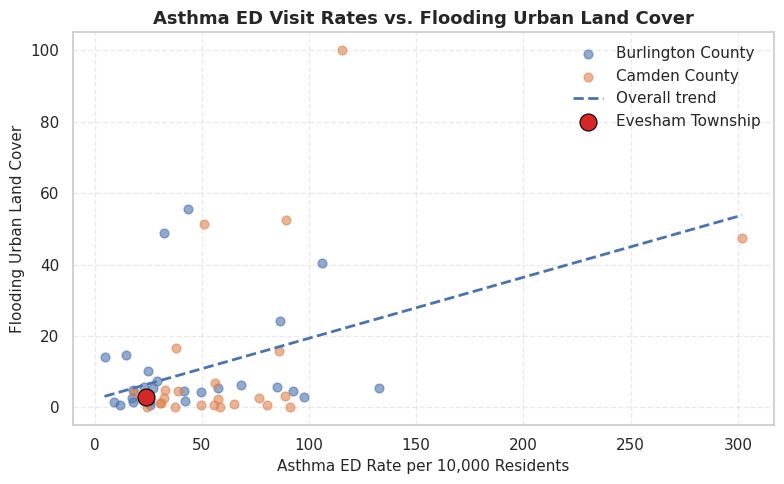

In [ ]:
county_scatterplot(
    x_col=COL_ASTHMA,
    y_col=COL_Flooding_Urban_Land_Cover,
    title="Asthma ED Visit Rates vs. Flooding Urban Land Cover",
    x_label="Asthma ED Rate per 10,000 Residents",
    y_label="Flooding Urban Land Cover"
)


This scatterplot shows the relationship between 'Asthma ED Visit Rates' and 'Flooding Urban Land Cover'. The plot reveals a weak positive correlation, suggesting that municipalities with higher proportions of urban land cover susceptible to flooding might have slightly higher asthma ED rates. However, the variable is zero-inflated, and Evesham Township (highlighted in red) is located in the lower-left quadrant, indicating both low flooding urban land cover and a low asthma ED visit rate. The correlation is not strong, and many municipalities have zero or very low flooding risk, making direct interpretation challenging.

Asthma vs Total_Population

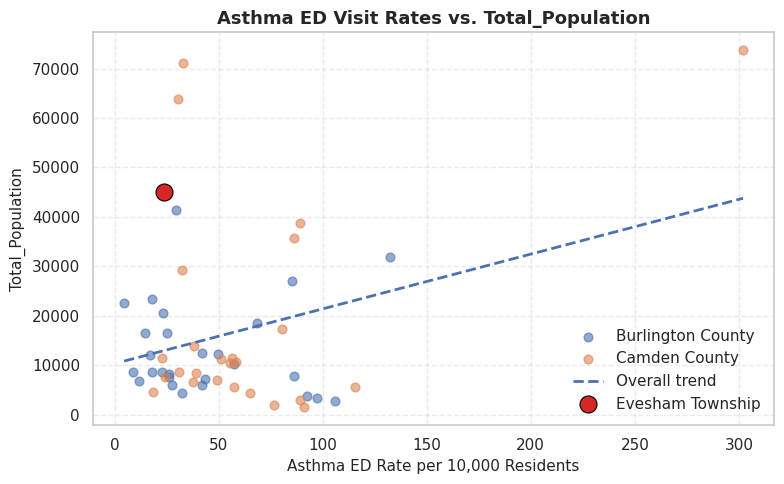

In [ ]:
county_scatterplot(
    x_col=COL_ASTHMA,
    y_col=COL_POPULATION,
    title="Asthma ED Visit Rates vs. Total_Population",
    x_label="Asthma ED Rate per 10,000 Residents",
    y_label="Total_Population"
)


This scatterplot examines the relationship between 'Asthma ED Visit Rates' and 'Total Population'. There appears to be no significant correlation between a municipality's total population and its asthma ED visit rate. The data points are broadly scattered, with no discernible trend. Evesham Township (highlighted in red) falls within the mid-range of population size and has a relatively low asthma ED visit rate, suggesting that population size alone is not a strong indicator for asthma emergency department utilization.

## **Descriptive Statistics & Statewide Ranking**


## Statewide Ranking of Evesham

We rank municipalities by asthma ED rate to understand where
Evesham falls in Burlington and Camden county.


In [ ]:
import pandas as pd
from scipy import stats

# -----------------------------
# 1. Prepare clean dataset
# -----------------------------
rank_cols = [COL_GEO, 'County', COL_ASTHMA]

df_rank = (
    nj_muni_df[rank_cols]
    .dropna(subset=[COL_ASTHMA])
    .copy()
)

# -----------------------------
# 2. Rank municipalities
#    Rank 1 = highest (worst) asthma ED rate
# -----------------------------
df_rank = df_rank.sort_values(COL_ASTHMA, ascending=False).reset_index(drop=True)
df_rank['State_Rank'] = df_rank.index + 1

total_munis = len(df_rank)

# -----------------------------
# 3. Get Evesham metrics
# -----------------------------
evesham_row = df_rank[df_rank[COL_GEO] == "Evesham Township"].iloc[0]

evesham_rank = int(evesham_row['State_Rank'])
evesham_rate = evesham_row[COL_ASTHMA]

# Percentile (higher = worse)
evesham_percentile = stats.percentileofscore(
    df_rank[COL_ASTHMA],
    evesham_rate
)

# -----------------------------
# 4. Print Evesham summary
# -----------------------------
print("\n" + "="*80)
print("EVESHAM TOWNSHIP: ASTHMA ED VISIT RANKING (Among Burlington and Camden County municipalities)")
print("="*80)

print(f"Asthma ED Visit Rate: {evesham_rate:.2f} per 10,000 residents")
print(f"Statewide Rank: {evesham_rank} out of {total_munis} municipalities")
print(f"Percentile: {evesham_percentile:.1f}th")

interpretation = (
    "higher" if evesham_percentile > 50 else "lower"
)

print(
    f"Interpretation: Evesham Township has a {interpretation} asthma "
    f"emergency department visit rate than approximately "
    f"{100-evesham_percentile:.1f}% of municipalities in New Jersey."
)

# -----------------------------
# 5. Top 15 and Bottom 15 tables
# -----------------------------
top_15 = df_rank.head(15)
bottom_15 = df_rank.tail(15)

print("\n" + "-"*80)
print("TOP 15 MUNICIPALITIES WITH HIGHEST ASTHMA ED VISIT RATES")
print("-"*80)
print(
    top_15[['State_Rank', COL_GEO, 'County', COL_ASTHMA]]
    .to_string(index=False)
)

print("\n" + "-"*80)
print("BOTTOM 15 MUNICIPALITIES WITH LOWEST ASTHMA ED VISIT RATES")
print("-"*80)
print(
    bottom_15[['State_Rank', COL_GEO, 'County', COL_ASTHMA]]
    .to_string(index=False)
)



EVESHAM TOWNSHIP: ASTHMA ED VISIT RANKING (Among Burlington and Camden County municipalities)
Asthma ED Visit Rate: 23.80 per 10,000 residents
Statewide Rank: 42 out of 53 municipalities
Percentile: 22.6th
Interpretation: Evesham Township has a lower asthma emergency department visit rate than approximately 77.4% of municipalities in New Jersey.

--------------------------------------------------------------------------------
TOP 15 MUNICIPALITIES WITH HIGHEST ASTHMA ED VISIT RATES
--------------------------------------------------------------------------------
 State_Rank State_Municipality_County     County  Asthma_ED_Rate_10k
          1               Camden City     Camden               302.0
          2      Willingboro Township Burlington               132.5
          3            Somerdale Boro     Camden               115.4
          4          Riverton Borough Burlington               106.1
          5      Springfield Township Burlington                97.5
          6      

## Displaying a Bar Graph Showing the Top 15 Burlington and Camden Municipalities with Highest Asthma ED Visit Rates

/tmp/ipython-input-2767476843.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


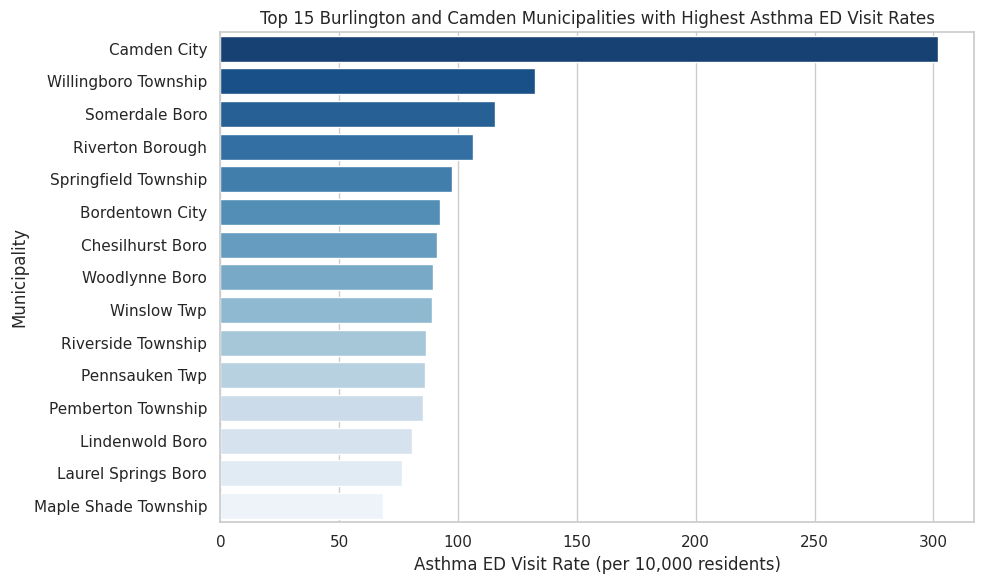

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

# Sort so lowest rate is lightest, highest is darkest (top after invert)
top_15 = df_rank.head(15).sort_values(COL_ASTHMA)

# Create a properly sized gradient palette
palette = sns.color_palette("Blues", n_colors=len(top_15))
palette = palette[::1]  # darkest = highest rate

plt.figure(figsize=(10, 6))

sns.barplot(
    data=top_15,
    x=COL_ASTHMA,
    y=COL_GEO,
    palette=palette)

plt.xlabel("Asthma ED Visit Rate (per 10,000 residents)")
plt.ylabel("Municipality")
plt.title("Top 15 Burlington and Camden Municipalities with Highest Asthma ED Visit Rates")

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


This bar chart highlights the top 15 municipalities in Burlington and Camden Counties with the highest asthma ED visit rates, with Willingboro Township showing the highest rate at 132.5. The visualization underscores the significant health disparities within the region, pinpointing specific communities that may require targeted public health interventions.

## Displaying a Bar Graph Showing the Bottom 15 Burlington and Camden County Municipalities with Lowest Asthma ED Visit Rates

/tmp/ipython-input-2782981153.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


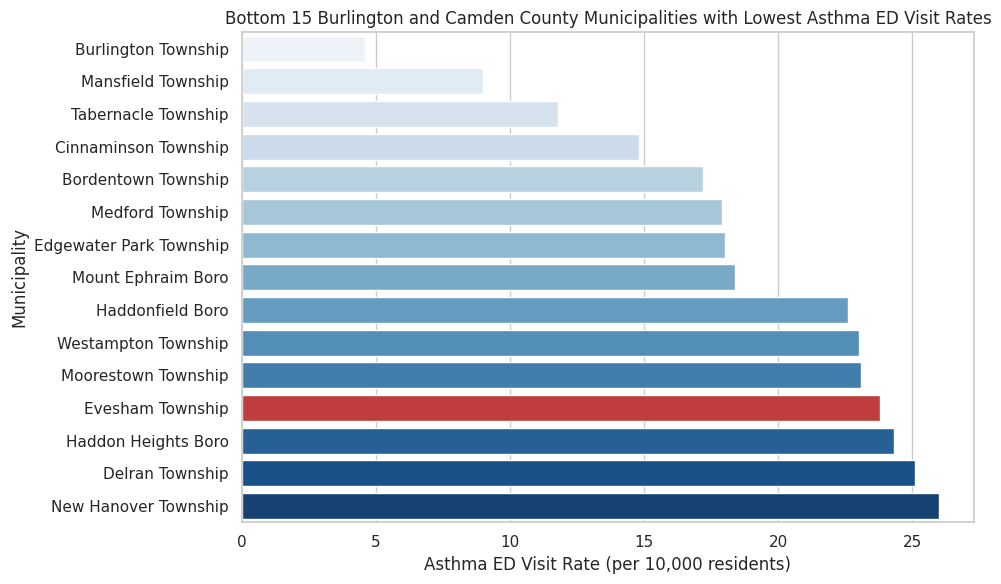

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

# Sort so lowest rate is lightest, highest is darkest (top after invert)
bottom_15 = df_rank.tail(15).sort_values(COL_ASTHMA)

# Create a gradient palette for all municipalities
base_palette = sns.color_palette("Blues", n_colors=len(bottom_15))

# Replace Evesham's color with red
palette = []
for i, municipality in enumerate(bottom_15[COL_GEO]):
    if municipality == 'Evesham Township':
        palette.append('#D62728')  # Red for Evesham
    else:
        palette.append(base_palette[i])  # Gradient blue for others

plt.figure(figsize=(10, 6))

sns.barplot(
    data=bottom_15,
    x=COL_ASTHMA,
    y=COL_GEO,
    palette=palette
)

plt.xlabel("Asthma ED Visit Rate (per 10,000 residents)")
plt.ylabel("Municipality")
plt.title("Bottom 15 Burlington and Camden County Municipalities with Lowest Asthma ED Visit Rates")

plt.tight_layout()
plt.show()

This bar chart displays the 15 New Jersey municipalities with the lowest asthma ED visit rates, with Camden City reporting the lowest value. Although Evesham Township is among the bottom 15, its rate indicates relatively low asthma ED utilization compared to the broader range of municipalities shown.

## Comparison to Peer Geographies


In [ ]:
METRICS = {
    COL_ASTHMA: "Asthma ED Rate (per 10k)",
    COL_POVERTY: "Poverty (% under 2x FPL)",
    COL_TRAFFIC: "High Traffic Exposure %",
    COL_MINORITY: "Minority Population %",
    COL_UNINSURED: "No Health Insurance %",
    COL_Air_Cancer_Risk: "Air Cancer Risk",
    COL_Air_Non_Cancer: "Air Non Cancer",
    COL_Air_Quality_Index: "Air Quality Index",
    COL_Flooding_Urban_Land_Cover: "Flooding Urban Land Cover"
}

def comparison_table(target_row, reference_df):
  # Initialize an empty list to store the data for each row of the comparison table.
    rows = []
    for col, label in METRICS.items():
      # Append a dictionary for the current metric, containing Evesham's value,
        # the mean of the reference group, and the difference between them.
        rows.append({
            "Metric": label,
            "Evesham": target_row[col],
            "Reference Mean": reference_df[col].mean(),
            "Difference": target_row[col] - reference_df[col].mean()
        })
    # Convert the list of row dictionaries into a pandas DataFrame and return it.
    return pd.DataFrame(rows)

# Re-initialize nj_muni_df, burlington_df, and camden_df to ensure they have all columns
# Also re-initialize evesham_row from the complete df.
evesham_row = df[
    (df[COL_GEO] == "Evesham Township") &
    (df[COL_LEVEL] == "Municipality")
].iloc[0]


nj_muni_df = df[df[COL_LEVEL] == "Municipality"].copy()
burlington_df = nj_muni_df[nj_muni_df[COL_COUNTY] == "Burlington"]
camden_df = nj_muni_df[nj_muni_df[COL_COUNTY] == "Camden"]

# Call the comparison_table function to compare Evesham Township (target_row)
# against municipalities in Burlington County (burlington_df) using the defined METRICS.
print(f"Comparing Evesham Township against municipalities in Burlington: \n{comparison_table(evesham_row, burlington_df)}")
print(f"Comparing Evesham Township against municipalities in Camden: \n{comparison_table(evesham_row, camden_df)}")

Comparing Evesham Township against municipalities in Burlington: 
                      Metric  Evesham  Reference Mean  Difference
0   Asthma ED Rate (per 10k)     23.8       44.017857  -20.217857
1   Poverty (% under 2x FPL)      9.6       15.357143   -5.757143
2    High Traffic Exposure %     14.1        7.782143    6.317857
3      Minority Population %     17.2       30.357143  -13.157143
4      No Health Insurance %      2.4        4.660714   -2.260714
5            Air Cancer Risk    115.0      135.642857  -20.642857
6             Air Non Cancer      2.0        2.425000   -0.425000
7          Air Quality Index      2.9        4.785714   -1.885714
8  Flooding Urban Land Cover      3.0       10.260714   -7.260714
Comparing Evesham Township against municipalities in Camden: 
                      Metric  Evesham  Reference Mean  Difference
0   Asthma ED Rate (per 10k)     23.8          65.156     -41.356
1   Poverty (% under 2x FPL)      9.6          24.152     -14.552
2    High Traf

## Hypothesis Testing

One-sample t-tests assess whether Evesham differs significantly
from Burlington County and Camden County municipalities.

- H₀: Evesham equals the county mean
- H₁: Evesham differs from the county mean


In [ ]:
#from scipy import stats

TEST_METRICS = {
    "Asthma_%_sqrt": "Asthma ED Rate (sqrt)",
    "Poverty_%_Under_2x_sqrt": "Poverty (% under 2x FPL) (sqrt)",
    "No_Health_Insurance_%_sqrt": "No Health Insurance % (sqrt)",
    "Traffic_%_1000ft_Heavy": "High Traffic Exposure %",
    "Minority_%_sqrt": "Minority Population % (sqrt)",
    COL_Air_Cancer_Risk: "Air Cancer Risk",
    COL_Air_Non_Cancer: "Air Non Cancer",
    COL_Air_Quality_Index: "Air Quality Index",
    COL_Flooding_Urban_Land_Cover: "Flooding Urban Land Cover"
}

def one_sample_test(reference_df, column, value):
    # Perform a one-sample t-test while ignoring NaN values
    t_stat, p_val = stats.ttest_1samp(
        reference_df[column],
        value,
        nan_policy='omit')

    return {
        "Metric": TEST_METRICS.get(column, column), # Use descriptive name from TEST_METRICS if available
        "t_stat": round(t_stat, 3),
        "p_value": round(p_val, 4),
        "Conclusion": "Reject H₀" if p_val < 0.05 else "Fail to reject H₀"
    }

results_burlington = [] # Initialize an empty list to store the results of each t-test for Burlington.
# Iterate through each metric defined in the TEST_METRICS dictionary (keys represent column names).
for col in TEST_METRICS.keys():
  # Perform a one-sample t-test for the current metric, comparing Burlington County municipalities
  # to Evesham Township's value for that metric.
    results_burlington.append(one_sample_test(burlington_df, col, evesham_row[col]))

results_camden = [] # Initialize an empty list to store the results of each t-test for Camden.
for col in TEST_METRICS.keys():
  # Perform a one-sample t-test for the current metric, comparing Camden County
  # to Evesham Township's value for that metric.
    results_camden.append(one_sample_test(camden_df, col, evesham_row[col]))

print(f"The results for Burlington County are: \n{pd.DataFrame(results_burlington)}") # Convert the list of test results into a pandas DataFrame for clear display.
print(f"The results for Camden County are: \n{pd.DataFrame(results_camden)}")

The results for Burlington County are: 
                            Metric  t_stat  p_value Conclusion
0            Asthma ED Rate (sqrt)   2.860   0.0081  Reject H₀
1  Poverty (% under 2x FPL) (sqrt)   3.815   0.0007  Reject H₀
2     No Health Insurance % (sqrt)   3.637   0.0011  Reject H₀
3          High Traffic Exposure %  -3.795   0.0008  Reject H₀
4     Minority Population % (sqrt)   3.594   0.0013  Reject H₀
5                  Air Cancer Risk   3.919   0.0005  Reject H₀
6                   Air Non Cancer   3.838   0.0007  Reject H₀
7                Air Quality Index   7.999   0.0000  Reject H₀
8        Flooding Urban Land Cover   2.662   0.0129  Reject H₀
The results for Camden County are: 
                            Metric  t_stat  p_value         Conclusion
0            Asthma ED Rate (sqrt)   5.169   0.0000          Reject H₀
1  Poverty (% under 2x FPL) (sqrt)   6.630   0.0000          Reject H₀
2     No Health Insurance % (sqrt)   6.658   0.0000          Reject H₀
3         

What are the comparisions between Camden and Burlington County?

## Multi-Level Bar Chart

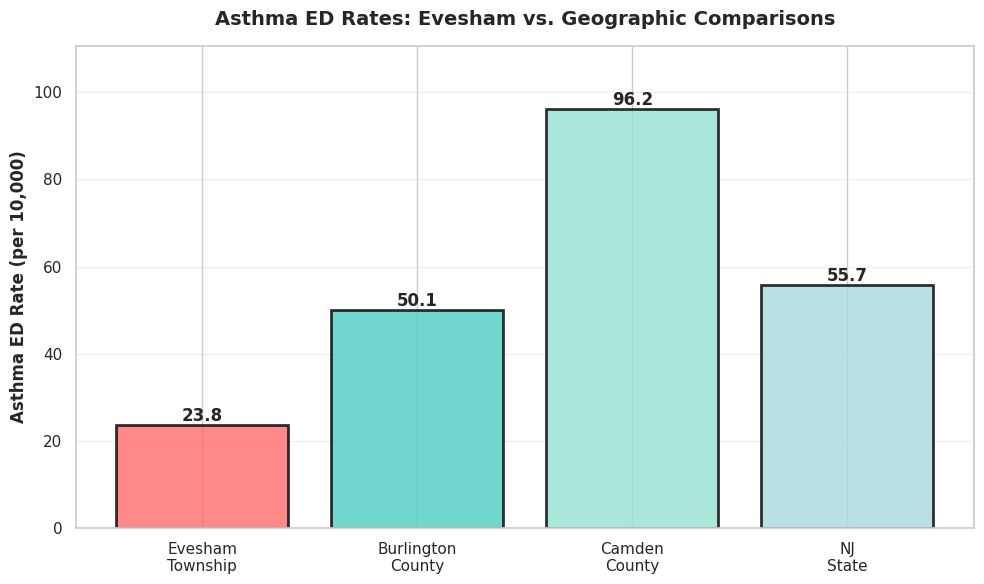

In [ ]:
# Bar chart comparing asthma rates
fig, ax = plt.subplots(figsize=(10, 6))

groups = ['Evesham\nTownship', 'Burlington\nCounty', 'Camden\nCounty', 'NJ\nState']
values = [
    evesham_row['Asthma_ED_Rate_10k'],
    burlington_county_row['Asthma_ED_Rate_10k'].mean(), # Calculate mean for Burlington County
    camden_county_row['Asthma_ED_Rate_10k'].mean(),     # Calculate mean for Camden County
    nj_row['Asthma_ED_Rate_10k'].mean()         # Calculate mean for NJ State
]
colors = ['#FF6B6B', '#4ECDC4', '#95E1D3', '#A8DADC']

bars = ax.bar(groups, values, color=colors, alpha=0.8, edgecolor='black', linewidth=2)

# Add value labels on bars
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.1f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Asthma ED Rate (per 10,000)', fontsize=12, fontweight='bold')
ax.set_title('Asthma ED Rates: Evesham vs. Geographic Comparisons',
             fontsize=14, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, max(values) * 1.15)

plt.tight_layout()
plt.show()

State_Municipality_County                                                Evesham Township
State_Municipality_County_Level_Type                                         Municipality
County                                                                         Burlington
Summary_Report_URL                      https://www.nj.gov/health/hcpnj/documents/coun...
Total_Population                                                                    45138
Poverty_%_Under_2x                                                                    9.6
Minority_%                                                                           17.2
No_Health_Insurance_%                                                                 2.4
Traffic_%_1000ft_Heavy                                                               14.1
Asthma_ED_Rate_10k                                                                   23.8
Air_Cancer_Risk                                                                       115
Air_Non_Ca

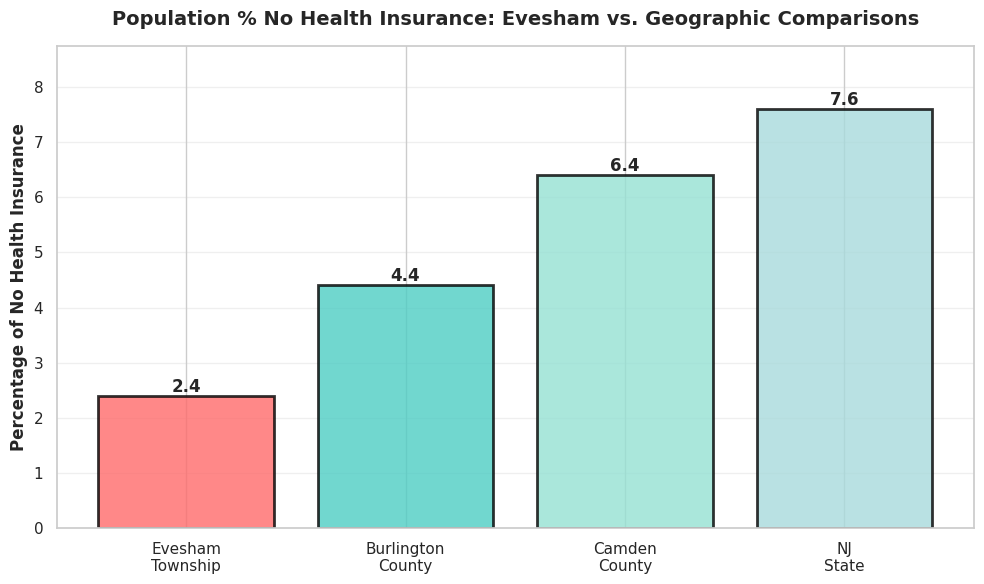

In [ ]:
# Bar chart comparing asthma rates
print(evesham_row)
fig, ax = plt.subplots(figsize=(10, 6))

groups = ['Evesham\nTownship', 'Burlington\nCounty', 'Camden\nCounty', 'NJ\nState']
values = [
    evesham_row['No_Health_Insurance_%'],
    burlington_county_row['No_Health_Insurance_%'].mean(), # Calculate mean for Burlington County
    camden_county_row['No_Health_Insurance_%'].mean(),     # Calculate mean for Camden County
    nj_row['No_Health_Insurance_%'].mean()         # Calculate mean for NJ State
]
colors = ['#FF6B6B', '#4ECDC4', '#95E1D3', '#A8DADC']

bars = ax.bar(groups, values, color=colors, alpha=0.8, edgecolor='black', linewidth=2)

# Add value labels on bars
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.1f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Percentage of No Health Insurance', fontsize=12, fontweight='bold')
ax.set_title('Population % No Health Insurance: Evesham vs. Geographic Comparisons',
             fontsize=14, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, max(values) * 1.15)

plt.tight_layout()
plt.show()

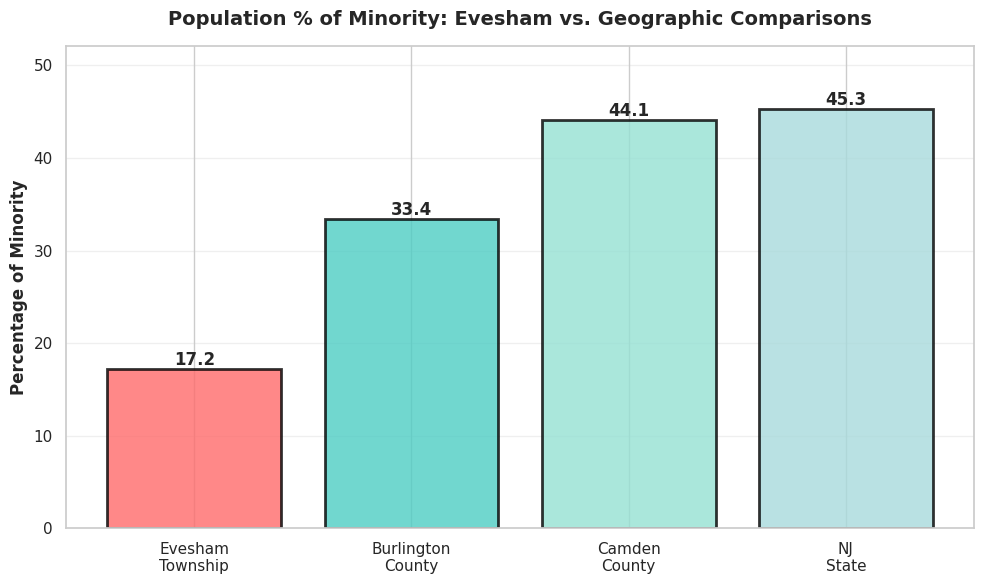

In [ ]:
# Bar chart comparing asthma rates
#print(evesham_row)
fig, ax = plt.subplots(figsize=(10, 6))

groups = ['Evesham\nTownship', 'Burlington\nCounty', 'Camden\nCounty', 'NJ\nState']
values = [
    evesham_row['Minority_%'],
    burlington_county_row['Minority_%'].mean(), # Calculate mean for Burlington County
    camden_county_row['Minority_%'].mean(),     # Calculate mean for Camden County
    nj_row['Minority_%'].mean()         # Calculate mean for NJ State
]
colors = ['#FF6B6B', '#4ECDC4', '#95E1D3', '#A8DADC']

bars = ax.bar(groups, values, color=colors, alpha=0.8, edgecolor='black', linewidth=2)

# Add value labels on bars
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.1f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Percentage of Minority', fontsize=12, fontweight='bold')
ax.set_title('Population % of Minority: Evesham vs. Geographic Comparisons',
             fontsize=14, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, max(values) * 1.15)

plt.tight_layout()
plt.show()

This bar chart compares Evesham Township's asthma ED rates against the average rates for Burlington County, Camden County, and the entire state of New Jersey. Evesham Township consistently shows a lower asthma ED rate compared to all these broader geographic areas, suggesting a more favorable outcome for its residents.

## Risk Stratification

Municipalities are grouped into relative risk categories using quantiles.


In [ ]:
# Create a 'poverty_group' column by dividing municipalities into 3 quantile-based groups (Low, Medium, High)
# based on their 'Poverty_%_Under_2x' values.
nj_muni_df["poverty_group"] = pd.qcut(nj_muni_df[COL_POVERTY], 3,
                                     labels=["Low", "Medium", "High"])

# Create an 'insurance_group' column by dividing municipalities into 2 quantile-based groups
# ('Mostly Insured', 'Higher Uninsured') based on their 'No_Health_Insurance_%' values.
nj_muni_df["insurance_group"] = pd.qcut(nj_muni_df[COL_UNINSURED], 2,
                                       labels=["Mostly Insured", "Higher Uninsured"])

# Create a 'traffic_group' column by dividing municipalities into 2 quantile-based groups
# ('Low Traffic', 'High Traffic') based on their 'Traffic_%_1000ft_Heavy' values.
nj_muni_df["traffic_group"] = pd.qcut(nj_muni_df[COL_TRAFFIC], 2,
                                     labels=["Low Traffic", "High Traffic"])

# Create a 'minority_group' column by dividing municipalities into 2 quantile-based groups
# ('Lower Minority', 'Higher Minority') based on their 'Minority_%' values.
nj_muni_df["minority_group"] = pd.qcut(nj_muni_df[COL_MINORITY], 2,
                                      labels=["Lower Minority", "Higher Minority"])

# Create an 'air_cancer_risk_group' column by dividing municipalities into 3 quantile-based groups
# (Low, Medium, High) based on their 'Air_Cancer_Risk' values.
nj_muni_df["air_cancer_risk_group"] = pd.qcut(
    nj_muni_df["Air_Cancer_Risk"],
    3,
    labels=["Low", "Medium", "High"]
)

# Create an 'air_non_cancer_group' column by dividing municipalities into 3 quantile-based groups
# (Low, Medium, High) based on their 'Air_Non_Cancer' values.
nj_muni_df["air_non_cancer_group"] = pd.qcut(
    nj_muni_df["Air_Non_Cancer"],
    3,
    labels=["Low", "Medium", "High"]
)

# Create an 'air_quality_group' column by dividing municipalities into 3 quantile-based groups
# (Good, Moderate, Poor) based on their 'Air_Quality_Index' values.
nj_muni_df["air_quality_group"] = pd.qcut(
    nj_muni_df["Air_Quality_Index"],
    3,
    labels=["Good", "Moderate", "Poor"]
)

# Create a 'flooding_urban_group' column by dividing municipalities into 2 quantile-based groups
# (Lower Risk, Higher Risk) based on their 'Flooding_Urban_Land_Cover' values.
nj_muni_df["flooding_urban_group"] = pd.qcut(
    nj_muni_df["Flooding_Urban_Land_Cover"],
    2,
    labels=["Lower Risk", "Higher Risk"]
)
nj_muni_df


,State_Municipality_County,State_Municipality_County_Level_Type,County,Summary_Report_URL,Total_Population,Poverty_%_Under_2x,Minority_%,No_Health_Insurance_%,Traffic_%_1000ft_Heavy,Asthma_ED_Rate_10k,...,Poverty_%_Under_2x_sqrt,No_Health_Insurance_%_sqrt,poverty_group,insurance_group,traffic_group,minority_group,air_cancer_risk_group,air_non_cancer_group,air_quality_group,flooding_urban_group
4,Bordentown City,Municipality,Burlington,https://www.nj.gov/health/hcpnj/documents/coun...,3808,16.4,23.0,2.9,13.7,92.4,...,4.049691,1.702939,Medium,Mostly Insured,High Traffic,Lower Minority,High,Medium,Good,Higher Risk
5,Bordentown Township,Municipality,Burlington,https://www.nj.gov/health/hcpnj/documents/coun...,12103,17.3,25.5,5.2,20.7,17.2,...,4.159327,2.280351,Medium,Higher Uninsured,High Traffic,Lower Minority,Medium,Low,Moderate,Lower Risk
7,Burlington Township,Municipality,Burlington,https://www.nj.gov/health/hcpnj/documents/coun...,22600,16.9,55.1,4.7,13.5,4.6,...,4.110961,2.167948,Medium,Higher Uninsured,High Traffic,Higher Minority,Medium,Medium,Poor,Higher Risk
9,Cinnaminson Township,Municipality,Burlington,https://www.nj.gov/health/hcpnj/documents/coun...,16429,9.2,14.5,3.8,11.2,14.8,...,3.033150,1.949359,Low,Mostly Insured,Low Traffic,Lower Minority,Medium,High,Moderate,Higher Risk
10,Delanco Township,Municipality,Burlington,https://www.nj.gov/health/hcpnj/documents/coun...,4448,19.0,30.0,6.6,0.0,32.4,...,4.358899,2.569047,Medium,Higher Uninsured,Low Traffic,Lower Minority,Medium,High,Poor,Higher Risk
11,Delran Township,Municipality,Burlington,https://www.nj.gov/health/hcpnj/documents/coun...,16502,15.2,18.8,5.3,11.5,25.1,...,3.898718,2.302173,Medium,Higher Uninsured,High Traffic,Lower Minority,Medium,Medium,Moderate,Higher Risk
12,Eastampton Township,Municipality,Burlington,https://www.nj.gov/health/hcpnj/documents/coun...,6015,8.6,47.8,10.6,0.0,27.4,...,2.932576,3.255764,Low,Higher Uninsured,Low Traffic,Higher Minority,Low,Low,Poor,Higher Risk
13,Edgewater Park Township,Municipality,Burlington,https://www.nj.gov/health/hcpnj/documents/coun...,8670,31.3,46.7,9.1,7.4,18.0,...,5.594640,3.016621,High,Higher Uninsured,Low Traffic,Higher Minority,Medium,Medium,Poor,Lower Risk
14,Evesham Township,Municipality,Burlington,https://www.nj.gov/health/hcpnj/documents/coun...,45138,9.6,17.2,2.4,14.1,23.8,...,3.098387,1.549193,Low,Mostly Insured,High Traffic,Lower Minority,Low,Low,Good,Lower Risk
16,Florence Township,Municipality,Burlington,https://www.nj.gov/health/hcpnj/documents/coun...,12535,17.1,26.9,3.1,4.0,42.2,...,4.135215,1.760682,Medium,Mostly Insured,Low Traffic,Lower Minority,Medium,Medium,Poor,Lower Risk


## Distribution Analysis


<Figure size 700x500 with 0 Axes>

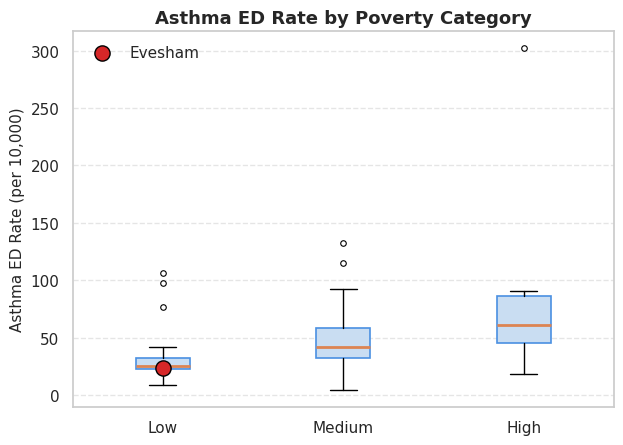

<Figure size 700x500 with 0 Axes>

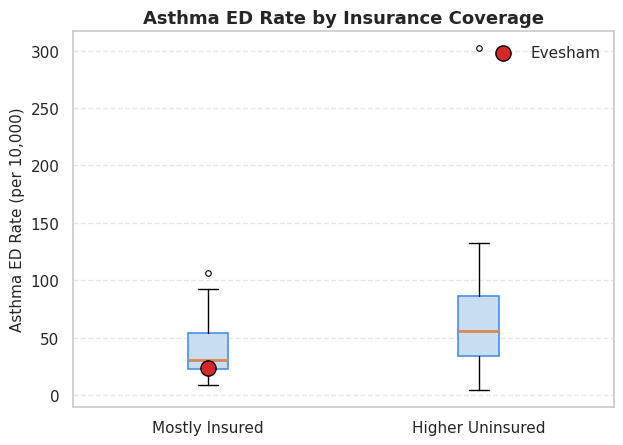

<Figure size 700x500 with 0 Axes>

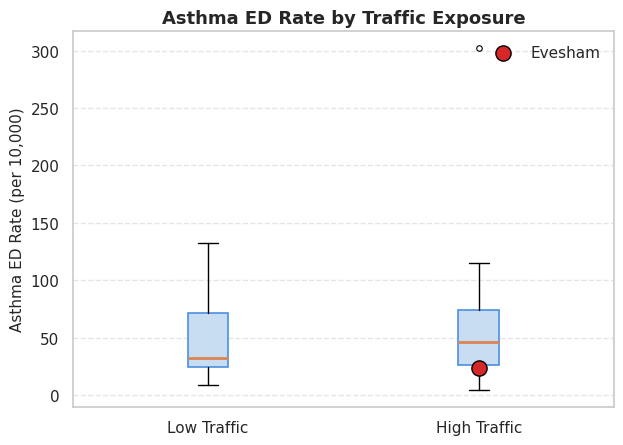

<Figure size 700x500 with 0 Axes>

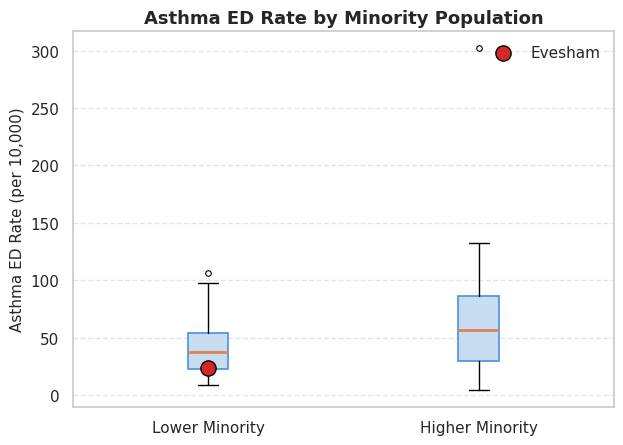

<Figure size 700x500 with 0 Axes>

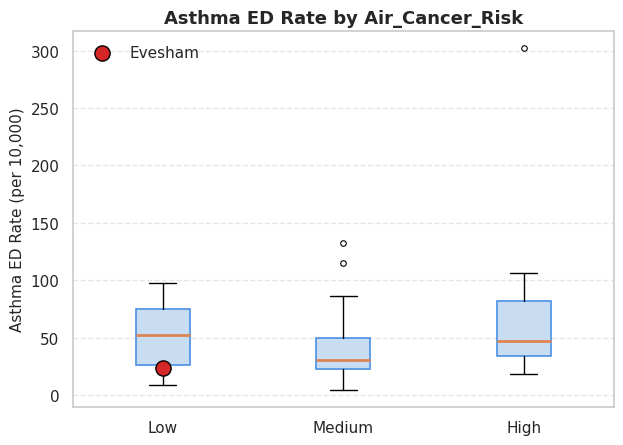

<Figure size 700x500 with 0 Axes>

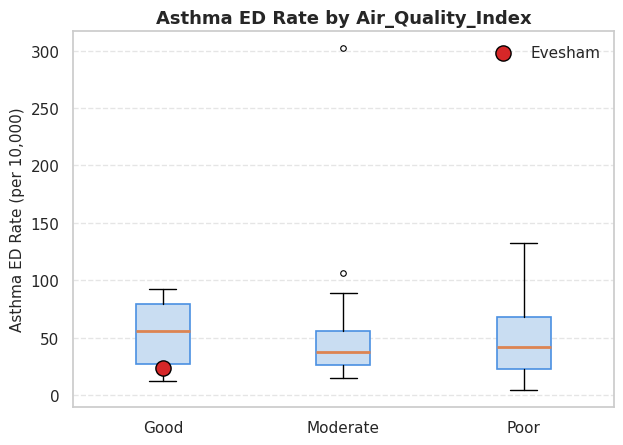

<Figure size 700x500 with 0 Axes>

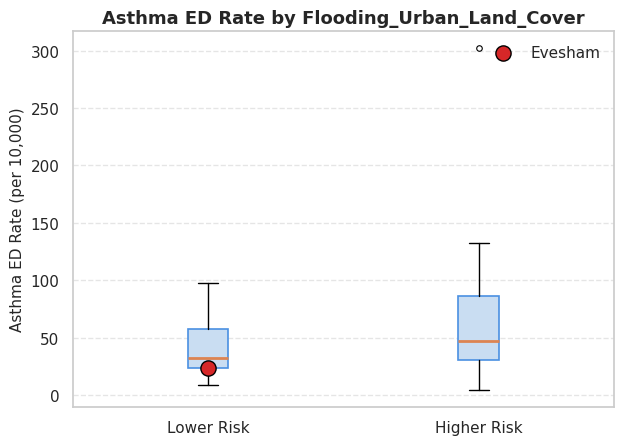

In [ ]:
# Re-extract evesham_row from the updated nj_muni_df so it includes the new group columns
evesham_row = nj_muni_df[
    (nj_muni_df[COL_GEO] == "Evesham Township")
].iloc[0]


def boxplot(group_col, title):
    plt.figure(figsize=(7,5))

    ax = nj_muni_df.boxplot(
        column=COL_ASTHMA,
        by=group_col,
        patch_artist=True,          # allows box coloring
        boxprops=dict(facecolor="#C9DDF2", edgecolor="#4A90E2", linewidth=1.2),
        medianprops=dict(linewidth=2),
        whiskerprops=dict(linewidth=1),
        capprops=dict(linewidth=1),
        flierprops=dict(
            marker='o',
            markersize=4,
            markerfacecolor='none',
            markeredgewidth=0.8
        )
    )

    # Get actual category order from axis
    categories = [tick.get_text() for tick in ax.get_xticklabels()]
    category_to_x = {cat: i + 1 for i, cat in enumerate(categories)}

    # Evesham position
    evesham_x = category_to_x[evesham_row[group_col]]

    # Plot Evesham point (clean, visible, professional)
    plt.scatter(
        evesham_x,
        evesham_row[COL_ASTHMA],
        s=120,
        color="#D62728",          # professional red
        edgecolor="black",        # subtle outline for contrast
        zorder=3,
        label="Evesham"
    )

    # Titles & labels
    plt.title(title, fontsize=13, weight="bold")
    plt.suptitle("")
    plt.xlabel("")
    plt.ylabel("Asthma ED Rate (per 10,000)", fontsize=11)

    # Grid styling
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.grid(axis="x", visible=False)

    # Legend styling
    plt.legend(frameon=False)

    plt.tight_layout()
    plt.show()


    # Generate a box plot for Asthma ED Rate by Poverty Category.
boxplot("poverty_group", "Asthma ED Rate by Poverty Category")
# Generate a box plot for Asthma ED Rate by Insurance Coverage.
boxplot("insurance_group", "Asthma ED Rate by Insurance Coverage")
# Generate a box plot for Asthma ED Rate by Traffic Exposure.
boxplot("traffic_group", "Asthma ED Rate by Traffic Exposure")
# Generate a box plot for Asthma ED Rate by Minority Population.
boxplot("minority_group", "Asthma ED Rate by Minority Population")

# Generate a box plot for Asthma ED Rate by Air_Cancer_Risk.
boxplot("air_cancer_risk_group", "Asthma ED Rate by Air_Cancer_Risk")
# Generate a box plot for Asthma ED Rate by Air_Quality_Index.
boxplot("air_quality_group", "Asthma ED Rate by Air_Quality_Index")
# Generate a box plot for Asthma ED Rate by Flooding_Urban_Land_Cover.
boxplot("flooding_urban_group", "Asthma ED Rate by Flooding_Urban_Land_Cover")

These boxplots collectively illustrate that socioeconomic factors like poverty, insurance coverage, and minority population percentage tend to show clearer associations with asthma ED rates, with Evesham Township generally positioned favorably in these categories. Conversely, environmental factors such as traffic exposure, air cancer risk, air quality index, and urban flooding risk generally exhibit weaker or less distinct relationships with asthma ED rates, suggesting their influence might be less pronounced or more complex in this dataset.

## Correlation Analysis: Does asthma ED visit depend on poverty, insurance traffic exposure, minority percentage?

In [ ]:
nj_muni_df.info()
correlation_matrix  = nj_muni_df[['Asthma_ED_Rate_10k', 'Poverty_%_Under_2x', 'No_Health_Insurance_%', 'Traffic_%_1000ft_Heavy', 'Minority_%', "Air_Cancer_Risk", "Air_Non_Cancer", "Air_Quality_Index", "Flooding_Urban_Land_Cover", 'Asthma_%_sqrt', 'Minority_%_sqrt', 'Poverty_%_Under_2x_sqrt', 'No_Health_Insurance_%_sqrt']].corr()
correlation_matrix

<class 'pandas.core.frame.DataFrame'>
Index: 53 entries, 4 to 76
Data columns (total 26 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   State_Municipality_County             53 non-null     object  
 1   State_Municipality_County_Level_Type  53 non-null     object  
 2   County                                53 non-null     object  
 3   Summary_Report_URL                    53 non-null     object  
 4   Total_Population                      53 non-null     int64   
 5   Poverty_%_Under_2x                    53 non-null     float64 
 6   Minority_%                            53 non-null     float64 
 7   No_Health_Insurance_%                 53 non-null     float64 
 8   Traffic_%_1000ft_Heavy                53 non-null     float64 
 9   Asthma_ED_Rate_10k                    53 non-null     float64 
 10  Air_Cancer_Risk                       53 non-null     int64   
 11  Air_Non_Cance

,Asthma_ED_Rate_10k,Poverty_%_Under_2x,No_Health_Insurance_%,Traffic_%_1000ft_Heavy,Minority_%,Air_Cancer_Risk,Air_Non_Cancer,Air_Quality_Index,Flooding_Urban_Land_Cover,Asthma_%_sqrt,Minority_%_sqrt,Poverty_%_Under_2x_sqrt,No_Health_Insurance_%_sqrt
Asthma_ED_Rate_10k,1.000000,0.640041,0.423196,0.165254,0.562902,0.166476,0.139005,-0.017576,0.403492,0.960121,0.494629,0.572975,0.433888
Poverty_%_Under_2x,0.640041,1.000000,0.702000,0.274815,0.668833,0.319475,0.263151,-0.126684,0.384935,0.615727,0.643723,0.983443,0.718204
No_Health_Insurance_%,0.423196,0.702000,1.000000,0.182150,0.511616,0.222703,0.219015,-0.014780,0.259568,0.462133,0.518660,0.702023,0.982526
Traffic_%_1000ft_Heavy,0.165254,0.274815,0.182150,1.000000,0.110291,0.519330,0.345130,0.171804,0.276156,0.191584,0.123454,0.295224,0.234293
Minority_%,0.562902,0.668833,0.511616,0.110291,1.000000,0.041596,0.165026,0.099080,0.280233,0.521991,0.980978,0.637622,0.530724
Air_Cancer_Risk,0.166476,0.319475,0.222703,0.519330,0.041596,1.000000,0.824521,0.445282,0.359795,0.126644,0.027072,0.289711,0.244148
Air_Non_Cancer,0.139005,0.263151,0.219015,0.345130,0.165026,0.824521,1.000000,0.545294,0.439759,0.096657,0.161461,0.237809,0.235574
Air_Quality_Index,-0.017576,-0.126684,-0.014780,0.171804,0.099080,0.445282,0.545294,1.000000,0.304020,-0.065016,0.123943,-0.154049,-0.001959
Flooding_Urban_Land_Cover,0.403492,0.384935,0.259568,0.276156,0.280233,0.359795,0.439759,0.304020,1.000000,0.388195,0.274483,0.359795,0.280024
Asthma_%_sqrt,0.960121,0.615727,0.462133,0.191584,0.521991,0.126644,0.096657,-0.065016,0.388195,1.000000,0.473808,0.578085,0.481904


Visualizing Correlations with a Heatmap

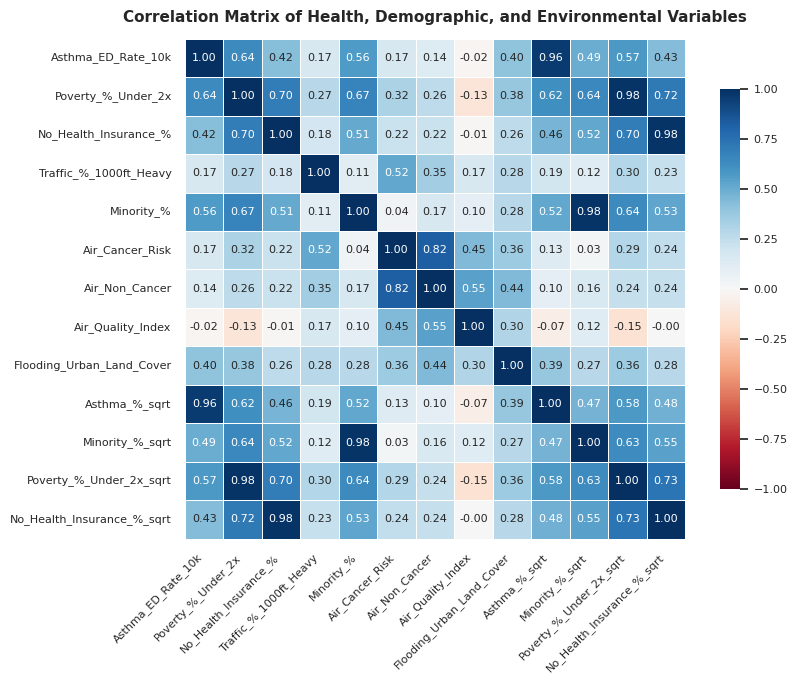

In [ ]:
plt.figure(figsize=(9,7))

ax = sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",                 # limit decimals
    cmap="RdBu",             # diverging, professional
    center=0,                  # center at zero correlation
    vmin=-1,
    vmax=1,
    linewidths=0.5,            # subtle gridlines
    linecolor="white",
    square=True,
    cbar_kws={"shrink": 0.8},
    annot_kws={"size": 8}    # Smaller font size for annotations
)

# Get the colorbar object and set its tick label font size
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=8)

plt.title(
    "Correlation Matrix of Health, Demographic, and Environmental Variables",
    fontsize=11,  # Smaller title font size
    weight="bold",
    pad=12
)

plt.xlabel("", fontsize=9) # Smaller x-axis label font size
plt.ylabel("", fontsize=9) # Smaller y-axis label font size
plt.xticks(rotation=45, ha="right", fontsize=8) # Smaller x-tick font size
plt.yticks(rotation=0, fontsize=8) # Smaller y-tick font size

plt.tight_layout()
plt.show()

The correlation matrix reveals moderate positive correlations between asthma ED rates and socioeconomic factors like poverty, uninsured percentage, minority population, suggesting these are key drivers. Conversely, environmental variables such as air quality and traffic show surprisingly weak or negligible correlations with asthma ED rates in this dataset.

In [ ]:
for col in correlation_matrix.columns:
    # Drop NaNs for the pair of variables
    temp_df = nj_muni_df[[col, COL_ASTHMA]].dropna()

    # Skip if not enough data
    if len(temp_df) < 2:
        print(f"{col}: Not enough data")
        continue

    x = temp_df[col].values.flatten()
    y = temp_df[COL_ASTHMA].values.flatten()

    corr, p_val = pearsonr(x, y)

    print(f"{col}: r = {corr:.3f}, p-value = {p_val:.4f}")



Asthma_ED_Rate_10k: r = 1.000, p-value = 0.0000
Poverty_%_Under_2x: r = 0.640, p-value = 0.0000
No_Health_Insurance_%: r = 0.423, p-value = 0.0016
Traffic_%_1000ft_Heavy: r = 0.165, p-value = 0.2370
Minority_%: r = 0.563, p-value = 0.0000
Air_Cancer_Risk: r = 0.166, p-value = 0.2335
Air_Non_Cancer: r = 0.139, p-value = 0.3209
Air_Quality_Index: r = -0.018, p-value = 0.9006
Flooding_Urban_Land_Cover: r = 0.403, p-value = 0.0027
Asthma_%_sqrt: r = 0.960, p-value = 0.0000
Minority_%_sqrt: r = 0.495, p-value = 0.0002
Poverty_%_Under_2x_sqrt: r = 0.573, p-value = 0.0000
No_Health_Insurance_%_sqrt: r = 0.434, p-value = 0.0012


We can see there is a weak positive correlation between poverty and asthma emergency department visit rates.
There is a significant positive correlation between percentage of people with no health insurance and asthma emergency department visits.
There is a significant positive correlation between minority percent and asthma emergency department visit rates.
There is a weak positive correlation between traffic percentage and asthma emergency department visit rates.



## Regression Analysis: Expected vs Actual

A linear regression estimates expected asthma ED rates based on
social determinants of health. This model is **contextual, not causal**.



Feature Selection

In [ ]:
#Drop the NA values
cols = [COL_ASTHMA, 'No_Health_Insurance_%_sqrt', COL_MINORITY]
df_model = nj_muni_df[cols].dropna()

# Dependent variable (y)
y = df_model[COL_ASTHMA]

# Independent variables (X)
X = df_model[['No_Health_Insurance_%_sqrt', COL_MINORITY]]
X.shape

(53, 2)

In [ ]:
#Check for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

                      feature       VIF
0  No_Health_Insurance_%_sqrt  4.806018
1                  Minority_%  4.806018


In [ ]:
#Split the data into training and testing subsets for evaluation.
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2,random_state=0)

Linear Regression

In [ ]:
#Linear Regression Model
lin = LinearRegression()
lin_scores = cross_val_score(lin, X_train, y_train, scoring="r2", cv=5)
print("Linear Regression Scores: %.2f +/- %.2f" % (lin_scores.mean(), lin_scores.std()))

Linear Regression Scores: -0.07 +/- 0.44


Random Forest Regressor

Train a random forest regressor

In [ ]:
#Default Random Forest
start = time.time()
rf = RandomForestRegressor(random_state=0)
rf_scores = cross_val_score(rf, X_train, y_train, scoring="r2", cv=5)
print("Random Forest Scores: %.2f +/- %.2f" % (rf_scores.mean(), rf_scores.std()))
print("time to run this experiment: %.2f"%(time.time()-start))

Random Forest Scores: -0.60 +/- 1.34
time to run this experiment: 0.75


Tuning Random Forest Model

In [ ]:
#Fine Tune the Random Forest Model
rf = RandomForestRegressor(random_state=0)
parameter = {"min_samples_leaf":[6,10,12]}
rf_grid1 = GridSearchCV(rf, parameter, scoring = "r2", cv = 5)
rf_grid1.fit(X_train, y_train)
print("best parameter of rf's min_sample_leaf parameter is: %s"%rf_grid1.best_params_)

best parameter of rf's min_sample_leaf parameter is: {'min_samples_leaf': 10}


In [ ]:
print("average of r2 across 10 folds for the best parameter: %.2f, std dev : %.2f"
      %(rf_grid1.best_score_, rf_grid1.cv_results_["std_test_score"][rf_grid1.best_index_]))

average of r2 across 10 folds for the best parameter: -0.22, std dev : 0.49


In [ ]:
rf_grid1.cv_results_["mean_test_score"]

array([-0.26777768, -0.21717035, -0.44026735])

In [ ]:
rf = RandomForestRegressor(random_state=0, min_samples_leaf=10)
parameter = {"n_estimators": list(range(20, 160, 20))}
rf_grid2 = GridSearchCV(rf, parameter, scoring="r2", cv=5)
rf_grid2.fit(X_train, y_train)
print("best parameter of rf's n_estimators parameter is: %s" % rf_grid2.best_params_)
print("average of r2 across 10 folds for the best parameter: %.2f, std dev : %.2f"
      %(rf_grid2.best_score_, rf_grid2.cv_results_["std_test_score"][rf_grid2.best_index_]))

best parameter of rf's n_estimators parameter is: {'n_estimators': 20}
average of r2 across 10 folds for the best parameter: -0.19, std dev : 0.40


In [ ]:
rf = RandomForestRegressor(random_state= 0, min_samples_leaf = 10, n_estimators = 40)
parameter = {"max_features": [6,7,8,9]}
rf_grid2 = GridSearchCV(rf, parameter, scoring = "r2", cv = 5)
rf_grid2.fit(X_train, y_train)
print("best parameter of rf's max_features parameter is: %s"%rf_grid2.best_params_)
print("average of r2 across 10 folds for the best parameter: %.2f, std dev : %.2f"
      %(rf_grid2.best_score_, rf_grid2.cv_results_["std_test_score"][rf_grid2.best_index_]))

best parameter of rf's max_features parameter is: {'max_features': 6}
average of r2 across 10 folds for the best parameter: -0.20, std dev : 0.42


In [ ]:
rf = RandomForestRegressor(random_state= 0, min_samples_leaf = 10, max_features= 6, n_estimators = 40)
rf.fit(X_train, y_train)

RandomForestRegressor(max_features=6, min_samples_leaf=10, n_estimators=40,
                      random_state=0)

Gradient Boosting

In [ ]:
#Default Gradient Boosting Model
start= time.time()
#initialize the gb model
gb = GradientBoostingRegressor(random_state=0)
gb_scores = cross_val_score(gb,
                            X_train, y_train,
                            scoring = "r2", cv = 4)
print("Default Gradient Boosting Model Scores: %.2f +/- %.2f"%(gb_scores.mean(), gb_scores.std()))
print("time to run this experiment: %.2f"%(time.time()-start))

Default Gradient Boosting Model Scores: -0.91 +/- 1.41
time to run this experiment: 0.22


In [ ]:
# Fine tune a GBM
# Define the model
# The list of hyper-parameters we want to optimize. For each one we define the
# bounds, the corresponding scikit-learn parameter name, as well as how to
# sample values from that dimension (`'log-uniform'` for the learning rate)
space = [Integer(60,100, name="n_estimators"),
            Integer(5, 12, name='max_depth'),
          Real(0.01, 1, "log-uniform", name='learning_rate'),
          Integer(2, 13, name='max_features'),
          Integer(100, 150, name='min_samples_split')]

gb = GradientBoostingRegressor(random_state=0)

# this decorator allows your objective function to receive a the parameters as
# keyword arguments.
@use_named_args(space)
def objective(**params):
    gb.set_params(**params)

    return -np.mean(cross_val_score(gb, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="r2"))

gb_gp_mae = gp_minimize(objective, space, n_calls=50, random_state=0)

In [ ]:
gb_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

"Best score=%.4f" % gb_gp.fun

'Best score=0.4939'

In [ ]:
#Print the best parameters
print("""Best parameters:
- n_estimators = %d
- max_depth=%d
- learning_rate=%.6f
- max_features=%d
- min_samples_split=%d""" %(gb_gp.x[0], gb_gp.x[1],
                            gb_gp.x[2], gb_gp.x[3],
                            gb_gp.x[4]))

Best parameters:
- n_estimators = 75
- max_depth=7
- learning_rate=0.012985
- max_features=5
- min_samples_split=124


In [ ]:
start = time.time()
gb = GradientBoostingRegressor(random_state=0, max_depth=8, learning_rate = 0.820938, n_estimators = 86, max_features = 4, min_samples_split = 144)
gb_scores = cross_val_score(gb, X_train, y_train, scoring = "r2", cv = 10)
print("Gradient Boosting Model Scores on the dataset: %.2f +/- %.2f"%(gb_scores.mean(), gb_scores.std()))
print("time to run this experiment: %.2f"%(time.time()-start))

Gradient Boosting Model Scores on the dataset: -1.04 +/- 1.58
time to run this experiment: 1.28


Model test on the test set

How does the linear regression model perform on the test dataset?

In [ ]:
#Model performance on testing set with linear regression model
lin.fit(X_train, y_train)
y_pred = lin.predict(X_valid)
r2_score(y_pred, y_valid)

-9.887872088293246

How does the random forest model perform on the test dataset?

In [ ]:
#Model performance on testing set with random forest
#rf.fit(X_train, y_train)
y_pred = rf.predict(X_valid)
r2_score(y_pred, y_valid)

-43.33314661415116

How does gradient boosting model perform on the test dataset?

In [ ]:
#Model performance on testing set with gradient boosting model
gb.fit(X_train, y_train)

y_pred = gb.predict(X_valid)
r2_score(y_pred, y_valid)

-1.246606060125145e+32

In [ ]:
# Add intercept (constant)
X = sm.add_constant(X)

In [ ]:
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Asthma_ED_Rate_10k   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     13.01
Date:                Mon, 19 Jan 2026   Prob (F-statistic):           2.82e-05
Time:                        02:16:58   Log-Likelihood:                -266.77
No. Observations:                  53   AIC:                             539.5
Df Residuals:                      50   BIC:                             545.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -6.0536     17.181     -0.352      0.726     -40.563      28.456
No_Health_Insurance_%_sqrt    11.9788      8.616      1.390      0.171      -5.327      29.285
Minority_%                     1.0093      0.295      3.422      0.001       0.417       1.602
==============================================================================
Omnibus:                       39.116   Durbin-Watson:                   1.749
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              143.456
Skew:                           1.937   Prob(JB):                     7.06e-32
Kurtosis:                      10.067   Cond. No.                         139.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# Model diagnostics
from statsmodels.stats.diagnostic import het_breuschpagan

# Test for heteroscedasticity
bp_test = het_breuschpagan(model.resid, model.model.exog)
print(f"Breusch-Pagan test: LM statistic = {bp_test[0]:.3f}, p = {bp_test[1]:.3f}")

# Check for normality of residuals
from scipy.stats import shapiro
shapiro_test = shapiro(model.resid)
print(f"Shapiro-Wilk test: W = {shapiro_test[0]:.3f}, p = {shapiro_test[1]:.3f}")

Breusch-Pagan test: LM statistic = 9.103, p = 0.011
Shapiro-Wilk test: W = 0.851, p = 0.000


## Expected vs Actual Asthma ED Rate for Evesham


In [ ]:
# Get the column names from the trained model's exogenous variables

exog_cols = model.model.exog_names

# Create a DataFrame for Evesham's features, including the constant term,
# and ensuring the column order matches the model's expectations.
evesham_X = pd.DataFrame(
    [[1.0,
      #evesham_row[COL_POVERTY],
      evesham_row['No_Health_Insurance_%_sqrt'],
      #evesham_row[COL_TRAFFIC],
      evesham_row[COL_MINORITY]]],
    columns=exog_cols
)

# Predict the Asthma ED Rate for Evesham Township using the trained model.
# The model.predict() method takes the feature DataFrame (evesham_X) as input.
# [0] is used to extract the single predicted value from the resulting array.
predicted = model.predict(evesham_X)[0]
# Retrieve the actual Asthma ED Rate for Evesham Township from the evesham_row Series.
actual = evesham_row[COL_ASTHMA]

# Display both the predicted and actual Asthma ED rates for comparison.
predicted, actual

(np.float64(29.863085541247774), np.float64(23.8))

**Count Risk Factors**

In [ ]:
risk_vars = [
    #COL_POVERTY,
    COL_UNINSURED,
    #COL_TRAFFIC,
    COL_MINORITY
]

# Standardize risk variables
risk_df = nj_muni_df[risk_vars]
risk_z = (risk_df - risk_df.mean()) / risk_df.std()

# Composite risk score
nj_muni_df["risk_score"] = risk_z.sum(axis=1)


Identify unusual municipalities with High asthma, low risk

In [ ]:
high_asthma_low_risk = nj_muni_df[
    (nj_muni_df[COL_ASTHMA] > nj_muni_df[COL_ASTHMA].quantile(0.75)) &
    (nj_muni_df["risk_score"] < nj_muni_df["risk_score"].quantile(0.25))
]


Low asthma, high risk

In [ ]:
low_asthma_high_risk = nj_muni_df[
    (nj_muni_df[COL_ASTHMA] < nj_muni_df[COL_ASTHMA].quantile(0.25)) &
    (nj_muni_df["risk_score"] > nj_muni_df["risk_score"].quantile(0.75))
]


Inspect Results

In [ ]:
high_asthma_low_risk[
    [COL_GEO, COL_ASTHMA, "risk_score"]
].sort_values(COL_ASTHMA, ascending=False)


,State_Municipality_County,Asthma_ED_Rate_10k,risk_score
32,Riverton Borough,106.1,-1.533484


Evesham Township consistently demonstrates a favorable profile with lower asthma ED visit rates and lower socioeconomic risk factors compared to many other municipalities in Burlington and Camden Counties and New Jersey overall. The analysis highlights that **socioeconomic factors (uninsured rates, minority population, poverty) are more strongly associated with asthma ED utilization than the environmental factors examined** in this dataset. This suggests that public health interventions aimed at improving healthcare access and addressing social determinants of health may be more impactful in reducing asthma-related ED visits than interventions solely focused on the environmental metrics included here. The modest explanatory power of the regression model indicates the complex, multifactorial nature of asthma ED utilization, emphasizing the need for comprehensive approaches that consider clinical, behavioral, and broader systemic influences.

